# import

In [1]:
import json
import matplotlib.pyplot as plt
import copy
import numpy as np
import statistics
import time
import warnings
import os
import random
import pandas as pd

dict_actions_b = {}
dict_predicates_b = {}
dict_objects_b = {}

dict_actions_b["pickup"] = (
    ["ob"],
    ["clear 0", "on-table 0", "arm-empty"],
    ["holding 0"],
    ["clear 0", "on-table 0", "arm-empty"],
)
dict_actions_b["putdown"] = (
    ["ob"],
    ["holding 0"],
    ["clear 0", "on-table 0", "arm-empty"],
    ["holding 0"],
)
dict_actions_b["stack"] = (
    ["ob", "ob"],
    ["clear 1", "holding 0"],
    ["clear 0", "on 0 1", "arm-empty"],
    ["clear 1", "holding 0"],
)
dict_actions_b["unstack"] = (
    ["ob", "ob"],
    ["clear 0", "on 0 1", "arm-empty"],
    ["clear 1", "holding 0"],
    ["clear 0", "on 0 1", "arm-empty"],
)

dict_predicates_b["clear"] = (["ob"],)
dict_predicates_b["on-table"] = (["ob"],)
dict_predicates_b["holding"] = (["ob"],)
dict_predicates_b["on"] = (["ob", "ob"],)
dict_predicates_b["arm-empty"] = ([""],)

dict_predicates_b["ob"] = (["ob"],)

#dict_objects_b["ob"] = ["a", "b", "c", "d", "e", "f", "g", "h", "i","j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v",
#                        "w", "x", "y", "z"]
dict_objects_b["ob"] = ["b"]

convert_action_b = {}
convert_action_b["ontable"] = "on-table"
convert_action_b["handempty"] = "arm-empty"
# convert_action_b[" a "] = " b1 "
# convert_action_b[" b "] = " b2 "
# convert_action_b[" c "] = " b3 "
# convert_action_b[" d "] = " b4 "
# convert_action_b[" e "] = " b5 "
# convert_action_b[" f "] = " b6 "
# convert_action_b[" g "] = " b7 "
# convert_action_b[" h "] = " b8 "
# convert_action_b[" i "] = " b9 "
# convert_action_b[" j "] = " b10 "
# convert_action_b[" k "] = " b11 "
# convert_action_b[" l "] = " b12 "
# convert_action_b[" m "] = " b13 "
# convert_action_b[" n "] = " b14 "
# convert_action_b[" o "] = " b15 " 
# convert_action_b[" p "] = " b16 "
# convert_action_b[" q "] = " b17 "
# convert_action_b[" r "] = " b18 "
# convert_action_b[" s "] = " b19 "
# convert_action_b[" t "] = " b20 "
# convert_action_b[" u "] = " b21 "
# convert_action_b[" v "] = " b22 "
# convert_action_b[" w "] = " b23 " 
# convert_action_b[" x "] = " b24 "
# convert_action_b[" y "] = " b25 "
# convert_action_b[" z "] = " b26 "
convert_action_b1 = {}

dict_actions_domain = {}
dict_predicates_domain = {}
dict_objects_domain = {}
convert_action_domain = {}
convert_action_domain1 = {}

dict_actions_domain["blocksworld"] = dict_actions_b
dict_predicates_domain["blocksworld"] = dict_predicates_b
dict_objects_domain["blocksworld"] = dict_objects_b
convert_action_domain["blocksworld"] = convert_action_b

def estrai_lettere(input):
    lettere = []
    for parola in input.split():
        if len(parola) == 1:
            if parola not in lettere:
                lettere.append(parola)
    return lettere

def initial_state(path):
    with open(path, "r") as f:
        righe = f.readlines()
        inizio = False
        state = ""        

        for riga in righe:
            riga = riga.strip().replace("(", "").replace(")", "").lower()           

            if riga == "":
                inizio = False
            if inizio:
                state += riga + " "
            if riga == ":init":
                inizio = True

    return state

def get_goals(path):
    goals = []
    with open(path, "r") as f:
        righe = f.readlines()
        for riga in righe:
            riga = riga.strip().replace("(", "").replace(")", "").replace(", ", " ").replace(",", " ").lower()
            riga = riga + " "
            goals.append(riga)
    return goals

def get_actions(path):
    actions = []
    with open(path, "r") as f:
        righe = f.readlines()
        for riga in righe:
            riga = riga.strip().replace("(", "").replace(")", "").replace("-", "").lower()            
            actions.append(riga)
    return actions


def unite_actions(input, keywords, domain, separator="_"):
    for conversion in convert_action_domain[domain].keys():         
        input = input.replace(conversion, convert_action_domain[domain][conversion])
    list_to_unite = input.split()    
    index_actions = []
    for idx, token in enumerate(list_to_unite):
        if token in keywords:            
            index_actions.append(idx)    
    index_actions.append(len(list_to_unite))
    new_list = []
    for i in range(len(index_actions) - 1):        
        new_action = " ".join(list_to_unite[index_actions[i] : index_actions[i + 1]])        
        new_list.append(new_action.replace(" ", separator))
    return new_list


def create_starting_structures(plan, domain):

    initial_states = (
        plan["input"].split("<|goals|>")[0].strip().split("<|startofplan|>")[1].strip()
    )  
       
    goal_states = (
        plan["input"].split("<|goals|>")[1].strip().split("<|actions|>")[0].strip()
    )
    
    initial_states = unite_actions(
        initial_states, list(dict_predicates_domain[domain].keys()), domain
    )
    goal_states = unite_actions(
        goal_states, list(dict_predicates_domain[domain].keys()), domain
    )
    if "<|endofplan|>" in plan["actions"]:
        actions = unite_actions(
            plan["actions"].split("<|endofplan|>").strip(),
            list(dict_actions_domain[domain].keys()),
            domain,
        )
    else:
        actions = unite_actions(
            plan["actions"], list(dict_actions_domain[domain].keys()), domain
        )
        
    
    dict_states = {}
    dict_goals = {}
    for init_state in initial_states:
        dict_states[init_state] = True
    for goal_state in goal_states:
        if goal_state in initial_states:
            dict_goals[goal_state] = True
        else:
            dict_goals[goal_state] = False    
    return (dict_states, dict_goals, actions)
def rimuovi_numeri(stringa):
    return "".join([i for i in stringa if not i.isdigit()])
def check_goals(states, goal_states, domain):
    all_goals_satisfied = True
    goals_unsatisfied_list = []
    goals_unsatisfied_list_nonumber = []
    # print(goal_states)
    for goal in goal_states.keys():
        # print("Analizzo il goal " + goal)
        if goal not in states.keys():
            goal_states[goal] = False
            all_goals_satisfied = False
            goals_unsatisfied_list.append(goal)
            goals_unsatisfied_list_nonumber.append(rimuovi_numeri(goal))
            # print("Il mio goal non è negli stati visti")
        elif states[goal] is False:
            goal_states[goal] = False
            all_goals_satisfied = False
            goals_unsatisfied_list.append(goal)
            goals_unsatisfied_list_nonumber.append(rimuovi_numeri(goal))
            # print("Il mio goal è negli stati visti falso")
        else:
            goal_states[goal] = True
            # print("Il mio goal è negli stati visti vero")
    if all_goals_satisfied is True:
        return (True, goal_states, "goals_succesfull")
    else:
        return (
            False,
            goal_states,
            "goals_not_succesfull",
            goals_unsatisfied_list_nonumber,
            goals_unsatisfied_list,
        )
def execute_action(states, action, domain):
    # Return a Tuple
    # in the first position the result True, False
    # in the second position the next state if result is True or the current state if it is False
    # in the third position the motivation of the wrong execution
    # split my action, on position 0 the action, then the objects
    # print(action)
    splitted_action = action.split("_")[0]  # prendo il nome della mia azione
    try:
        action_parameter = dict_actions_domain[domain][
            splitted_action
        ]  # verifico che l'azione esiste
    except:
        action_parameter = None
    if action_parameter is None:
        return (False, states, "action_name_wrong", splitted_action, action, "")
    splitted_objects = action.split("_")[
        1:
    ]  # ottengo il nome dei miei oggetti definiti nel mio problema
    action_objects = action_parameter[0]  # ottengo gli oggetti accettati dall'azione
    if len(action_objects) == len(
        splitted_objects
    ):  # verifico che gli oggetti siano in egual numero rispetto a quanti ne richiede la mia azione
        for i in range(0, len(action_objects)):  # scorro i miei oggetti
            obj_nonumber = "".join(
                [j for j in splitted_objects[i] if not j.isdigit()]
            )  # calcolo il mio nome dell'oggetto senza tener conto dei numeri
            if (
                obj_nonumber not in dict_objects_domain[domain][action_objects[i]]
            ):  # verifico che l'oggetto si trovi nella lista di nomi possibili associata alla descrizione dell'azione
                print("Errore: " + obj_nonumber + " non è un oggetto valido per " + action_objects[i])
                print("Gli oggetti validi sono: " + str(dict_objects_domain[domain][action_objects[i]]))
                return (
                    False,
                    states,
                    "object_name_wrong",
                    splitted_action,
                    obj_nonumber,
                    splitted_objects[i],
                )
    else:
        return (
            False,
            states,
            "object_number_wrong",
            splitted_action,
            len(action_objects),
            len(splitted_objects),
        )

    action_prec = action_parameter[1]  # prendo le precondizioni della mia azione
    violed_precondtion = False
    violed_preconditions_list = []
    violed_preconditions_list_nonumber = []
    for prec in action_prec:  # scorro le mie precondizioni
        prec_list = prec.split(" ")
        prec_parametrized = "" + prec_list[0]  # metto il mio predicato
        for obj in prec_list[1:]:  # scorro gli oggetti della mia precondizione
            prec_parametrized = (
                prec_parametrized + "_" + splitted_objects[int(obj)]
            )  # sostituisco gli oggetti generici ai miei oggetti del problema
        if (
            prec_parametrized not in states.keys()
        ):  # controllo se la mia precondizione esiste come chiave del dizionario (se non esiste non è vera)
            violed_precondtion = True
            violed_preconditions_list.append(prec_parametrized)
            violed_preconditions_list_nonumber.append(rimuovi_numeri(prec_parametrized))
        elif (
            states[prec_parametrized] is False
        ):  # controllo che la mia precondizione sia vera per eseguire l'azione
            violed_precondtion = True
            violed_preconditions_list.append(prec_parametrized)
            violed_preconditions_list_nonumber.append(rimuovi_numeri(prec_parametrized))
        else:
            pass
    if violed_precondtion is True:
        return (
            False,
            states,
            "violed_preconditions",
            violed_preconditions_list_nonumber,
            violed_preconditions_list,
            splitted_action,
        )

    # eseguo gli effetti negativi
    action_neg = action_parameter[3]  # prendo i miei effetti negativi
    for neg in action_neg:  # li scorro
        neg_list = neg.split(" ")
        neg_parametrized = "" + neg_list[0]  # ottengo il mio predicato
        for obj in neg_list[1:]:  # per ogni oggetto (rappresentato come indice)
            neg_parametrized = (
                neg_parametrized + "_" + splitted_objects[int(obj)]
            )  # vado a sostituirlo col corrispettivo dell'azione in corso
        states[neg_parametrized] = False  # cambio il valore nei miei stati
        # print("ho reso falso " + neg_parametrized)

    # eseguo gli effetti additivi
    action_plus = action_parameter[2]  # prendo i miei effetti additivi
    for plus in action_plus:  # li scorro
        plus_list = plus.split(" ")
        plus_parametrized = "" + plus_list[0]  # ottengo il mio predicato
        for obj in plus_list[1:]:  # per ogni oggetto (rappresentato come indice)
            plus_parametrized = (
                plus_parametrized + "_" + splitted_objects[int(obj)]
            )  # vado a sostituirlo col corrispettivo dell'azione in corso
        states[plus_parametrized] = True  # cambio il valore nei miei stati
        # print("ho reso vero " + plus_parametrized)

    return (True, states, "action_succesfull")
def check_violated_preconditions(plan, domain):
    init_structures = create_starting_structures(plan, domain)
    init_state = init_structures[0]
    goal_state = init_structures[1]
    actions = init_structures[2]
    if len(actions) == 0 and len(plan["actions"]) != 0:
        return True  # Il modello ha generato i token iniziali diversi da azioni (parole a caso)
    # print("Actions ", actions)
    result_goals = check_goals(init_state, goal_state, domain)
    state = init_state
    for action in actions:
        result = execute_action(state, action, domain)
        # print("Res action ", result)
        if result[0] is True:
            state = result[1]
        else:
            error_type = result[2]
            if error_type == "object_name_wrong":
                return True
            elif error_type == "object_number_wrong":
                if result[4] > result[5]:
                    return False
                else:
                    return True
            elif error_type == "violed_preconditions":
                return True
            elif error_type == "action_name_wrong":
                return True
    return False
def calculate_reward(plan, domain):    
  
    init_structures = create_starting_structures(plan, domain)
    init_state = init_structures[0]
    goal_state = init_structures[1]
    actions = init_structures[2]

    start = time.time()

    result_goals = check_goals(init_state, goal_state, domain)
    if result_goals[0] is True:
        return 1
    else:
        pass
    state = init_state
    j = 0
    for action in actions:
        start_act = time.time()
        result = execute_action(state, action, domain)
        if result[0] is True:
            # print(result[2])
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)
            if result_goals[0] is True:
                return 1
            else:
                pass
                # print(result_goals[2])
        else:
            result_goals = check_goals(state, goal_state, domain)
            goals_satisfied = result_goals[1]
            count = 0
            n_goals = len(goals_satisfied.keys())
            for goal in goals_satisfied.keys():
                if goals_satisfied[goal] is True:
                    count += 1
            if check_violated_preconditions(plan, domain) is True:
                return (count / n_goals) - 1
            else:
                return count / n_goals
        j = j + 1
        end_act = time.time()
        # print("Ho impiegato per fare una azione: " + str(end_act-start_act))

    number_missing_actions = len(actions) - j
    end = time.time()
    # print("Ho impiegato " + str(end-start))
    goals_satisfied = result_goals[1]
    count = 0
    n_goals = len(goals_satisfied.keys())
    for goal in goals_satisfied.keys():
        if goals_satisfied[goal] is True:
            count += 1
    return count / n_goals

def parse_problem(plan, domain):  
            
    init_structures = create_starting_structures(plan, domain) # riporta i dizionari dei fluenti iniziali e dei fluenti obiettivo e l'inisieme delle azioni generate
    init_state = init_structures[0]  # dizionario con tutti i fluenti iniziali con assocciato il valore true
    goal_state = init_structures[1]  # dizionario con i fluenti obiettivo con associato il valore true o false in base ai fluenti iniziali
    actions = init_structures[2]     # vettore contenente le azioni generate da planGPT
    
    start = time.time()

    result_goals = check_goals(init_state, goal_state, domain)   
        
    if result_goals[0] is True:
        return (result_goals[0], result_goals[1], result_goals[2], len(actions))
        # print(result_goals[2])
    else:
        pass
        # print(result_goals[2])

    state = init_state    
    j = 0
    for action in actions:
        start_act = time.time()
        result = execute_action(state, action, domain)
        if result[0] is True:
            # print(result[2])
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)
            if result_goals[0] is True:
                # print(result_goals[2])
                j = j + 1
                break
            else:
                pass
                # print(result_goals[2])
        else:
            result_goals = check_goals(state, goal_state, domain)
            return (
                result[0],
                result_goals[1],
                result[2],
                result[3],
                result[4],
                result[5],
                j,
            )
            # print(result[2])
            # print(result[1])
            break
        j = j + 1
        end_act = time.time()
        # print("Ho impiegato per fare una azione: " + str(end_act-start_act))

    number_missing_actions = len(actions) - j
    end = time.time()
    # print("Ho impiegato " + str(end-start))
    return (result_goals[0], result_goals[1], result_goals[2], number_missing_actions)

def calculate_default_reward(init_state, goal_state, actions, domain, use_percentage, no_penalty):
    result_goals = check_goals(init_state, goal_state, domain)
    if result_goals[0] is True:
        if use_percentage is True:
            return 1
        else:
            return len(result_goals[1].keys())
    else:
        pass
    state = init_state
    j = 0
    for action in actions:
        start_act = time.time()
        result = execute_action(
            state, action, domain
        )  # Eseguo l'azione e ne verifico la correttezza
        if result[0] is True:  # Se l'azione e' eseguibile tutto ok
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)
            if result_goals[0] is True:
                if use_percentage is True:
                    return 1
                else:
                    return len(result_goals[1].keys())
            else:
                pass  # Non ho raggiunto i goals...continuo
        else:  # Se l'azione non e' eseguibile -> controllo quanti goals sono e penalizzo
            result_goals = check_goals(state, goal_state, domain)
            goals_satisfied = result_goals[1]
            count = 0
            n_goals = len(goals_satisfied.keys())
            for goal in goals_satisfied.keys():
                if goals_satisfied[goal] is True:
                    count += 1
            if no_penalty is True:
                if use_percentage is True:
                    return count / n_goals
                else:
                    return count
            else:
                # Occorre penalizzare qui
                if use_percentage is True:
                    return (count / n_goals) - 1
                else:
                    return count - (1 * n_goals)
        j = j + 1
        end_act = time.time()

    number_missing_actions = len(actions) - j
    end = time.time()
    goals_satisfied = result_goals[1]
    count = 0
    n_goals = len(goals_satisfied.keys())
    for goal in goals_satisfied.keys():
        if goals_satisfied[goal] is True:
            count += 1
    if use_percentage is True:
        return count / n_goals
    else:
        return count
    
def distribute_reward_to_tokens(actions, rewards, reward_eos=0.0, penalty_unused_actions=0.0):
    if len(actions) == 0:
        return [rewards[0]]
    token_reward_list = (
        []
    )  # Skippo il primo reward perchè è il reward per lo stato iniziale

    if len(actions) == (len(rewards) - 1):
        # print("Ok")
        pass
    else:
        # print("The plan reaches the goals and generates more actions")
        for i in range(len(actions) - len(rewards) + 1):
            rewards.append(penalty_unused_actions)
            reward_eos = 0.0  # ha generato azioni in più in cui non si ha una verifica delle precondizioni, quindi EOS non è detto sia corretto

    for index in range(0, len(actions)):
        action = actions[index]
        reward = rewards[index + 1]
        # TODO qui potrei passare il tokenizer.
        token_action_len = len(action.strip().split("_"))
        for i in range(0, token_action_len):
            token_reward_list.append(reward)
    token_reward_list.append(reward_eos)
    return token_reward_list

def compute_reward(rewards, discount_factor=0.99, reward_type="standard"):
    if reward_type == "standard":
        rewards.reverse()
        reward_sum = 0
        for reward in rewards:
            reward_sum = reward_sum * discount_factor + reward
        return reward_sum

    elif reward_type == "cumulative":
        reward_sum = 0
        reward_list = []
        exp_count = 0
        for reward in rewards:
            reward_sum = reward_sum + (discount_factor**exp_count) * reward
            reward_list.append(reward_sum)
            exp_count += 1
        return reward_list

    elif reward_type == "distributed":
        reward_list = []
        exp_count = 0
        for reward in rewards:
            current = (discount_factor**exp_count) * reward
            reward_list.append(current)
            exp_count += 1
        return reward_list
    else:
        raise ValueError(f"Invalid reward type {reward_type}")

def calculate_discounted_reward(
    init_state,
    goal_state,
    actions,
    domain,
    use_percentage,  # fornisce un reward compreso fra 0 e 1
    no_penalty,  # se non inserire una penalty qualora vi sia una violazione di una precondizione
    discount_factor,  # discount factor da applicare
    reward_type,  # distributed, cumulative
    reward_eos=False,  # se porre un reward sull'eos qualora tutti i goals sono soddisfatti
    penalty_unused_actions=False,  # se penalty alle azioni inutili dopo aver soddisfatto tutti i goals
):
    rewards = []
    n_goals = len(goal_state.keys())
    new_goal_satisfied = {}
    for goal in goal_state.keys():
        new_goal_satisfied[goal] = False

    vectorized_rewards = (reward_type == "distributed") or (reward_type == "cumulative")

    # controllo quali goals sono soddisfatti nello stato iniziale
    result_goals = check_goals(init_state, goal_state, domain)
    goal_satisfied_count = 0
    for goal in goal_state.keys():
        if (
            result_goals[1][goal] is True and new_goal_satisfied[goal] is True
        ):  # se un goal è già soddisfatto
            pass
        elif (
            result_goals[1][goal] is False and new_goal_satisfied[goal] is True
        ):  # un goal che era soddisfatto non è più soddisfatto
            pass
        elif (
            result_goals[1][goal] is False and new_goal_satisfied[goal] is False
        ):  # il goal non è soddisfatto
            pass
        else:  # abbiamo soddisfatto un goal (result_goals[1][goal] is True and new_goal_satisfied[goal] is False)
            goal_satisfied_count += 1
            new_goal_satisfied[goal] = True
    if use_percentage is True:
        rewards.append(
            goal_satisfied_count / n_goals
        )  # dividendo per il numero di goal, ottengo una frazione compreso fra 0 e 1 per ogni goal
    else:
        rewards.append(goal_satisfied_count)

    # aggiungo il reward EoS (ovvero 1 o il numero di goals soddisfatti)
    coeff_percentage_eos = 1 if use_percentage else n_goals
    reward_eos = coeff_percentage_eos if reward_eos else 0.0
    ### calcolo dei coefficienti per le azioni non usate (per distribuire i rewards nei tokens)
    coeff_penalty_unused_actions = -0.1 if use_percentage is True else -1
    penalty_unused_actions = (
        coeff_penalty_unused_actions if penalty_unused_actions else 0.0
    )

    if (
        result_goals[0] is True
    ):  # se ho già soddisfatto tutti i goals, e quindi, il mio piano è soddisfatto già nello stato iniziale
        ### distribuisco il reward sui vari tokens
        if vectorized_rewards:
            return distribute_reward_to_tokens(
                actions,
                compute_reward(
                    rewards,
                    discount_factor=discount_factor,
                    reward_type=reward_type,
                ),
                reward_eos=reward_eos,
                penalty_unused_actions=penalty_unused_actions,
            )
        else:
            return compute_reward(
                rewards,
                discount_factor=discount_factor,
                reward_type=reward_type,
            )
    else:
        pass

    state = init_state
    j = 0
    for action in actions:
        result = execute_action(state, action, domain)
        if result[0] is True:
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)

            # valuto quanti goal la mia azione ha soddisfatto
            goal_satisfied_count = 0
            for goal in goal_state.keys():
                if (
                    result_goals[1][goal] is True and new_goal_satisfied[goal] is True
                ):  # se un goal è già soddisfatto
                    pass
                elif (
                    result_goals[1][goal] is False and new_goal_satisfied[goal] is True
                ):  # un goal che era soddisfatto non è più soddisfatto
                    pass
                elif (
                    result_goals[1][goal] is False and new_goal_satisfied[goal] is False
                ):  # il goal non è soddisfatto
                    pass
                else:  # abbiamo soddisfatto un goal (result_goals[1][goal] is True and new_goal_satisfied[goal] is False)
                    goal_satisfied_count += 1
                    new_goal_satisfied[goal] = True
            if use_percentage is True:
                rewards.append(goal_satisfied_count / n_goals)
            else:
                rewards.append(goal_satisfied_count)

            if result_goals[0] is True:
                if vectorized_rewards:
                    return distribute_reward_to_tokens(
                        actions,
                        compute_reward(
                            rewards,
                            discount_factor=discount_factor,
                            reward_type=reward_type,
                        ),
                        reward_eos=reward_eos,
                        penalty_unused_actions=penalty_unused_actions,
                    )
                else:
                    return compute_reward(
                        rewards,
                        discount_factor=discount_factor,
                        reward_type=reward_type,
                    )

        else:  # Qui succede quando un azione ROMPE le precondizioni
            if no_penalty is False:  # se voglio penalizzare...
                if use_percentage is True:
                    rewards.append(-1.0)
                else:
                    rewards.append(-1 * n_goals)

            if vectorized_rewards:
                reward_eos = 0.0
                penalty_unused_actions = 0.0
                return distribute_reward_to_tokens(
                    actions,
                    compute_reward(
                        rewards,
                        discount_factor=discount_factor,
                        reward_type=reward_type,
                    ),
                    reward_eos=reward_eos,
                    penalty_unused_actions=penalty_unused_actions,
                )
            else:
                return compute_reward(
                    rewards,
                    discount_factor=discount_factor,
                    reward_type=reward_type,
                )

    if vectorized_rewards:
        reward_eos = 0.0
        coeff_penalty_unused_actions = 0.0
        return distribute_reward_to_tokens(
            actions,
            compute_reward(
                rewards,
                discount_factor=discount_factor,
                reward_type=reward_type,
            ),
            reward_eos=reward_eos,
            penalty_unused_actions=penalty_unused_actions,
        )
    else:
        return compute_reward(
            rewards,
            discount_factor=discount_factor,
            reward_type=reward_type,
        )


def calculate_reward(
    plan,
    domain,
    discounted=False,
    discount_factor=0.99,
    use_percentage=True,
    no_penalty=False,
    traslated_reward=False,
    use_reward_eos=False,
    use_penalty_unused_actions=False,
    reward_type="standard",
):
    
    # Creo le strutture necessarie
    init_structures = create_starting_structures(plan, domain)
    init_state = init_structures[0]
    goal_state = init_structures[1]
    actions = init_structures[2]
    start = time.time()

    # Calcolo il reward

    if discounted is False and reward_type in ["replicated", "standard"]:
        score = calculate_default_reward(
            init_state, goal_state, actions, domain, use_percentage, no_penalty
        )
        if traslated_reward is True and no_penalty is False:
            if use_percentage:
                score = (score + 1) / 2.0
            else:
                score = (score + len(goal_state.keys())) / 2.0
        if reward_type == "standard":
            return score
        else:
            # creo un vettore di dimensione uguale al numero di azioni+1
            # e assegno a ciascuna azione il reward ottenuto
            score = [score for i in range(len(actions) + 1)]
            final_score = distribute_reward_to_tokens(actions, score)
            return final_score

    # Discounted rewards richiede di mantenere in memoria una lista di rewards per ora non funziona con replicated.
    if discounted is True and reward_type in ["standard", "distributed", "cumulative"]:
        score = calculate_discounted_reward(
            init_state,
            goal_state,
            actions,
            domain,
            use_percentage,
            no_penalty,
            discount_factor,
            reward_type,
            reward_eos=use_reward_eos,
            penalty_unused_actions=use_penalty_unused_actions,
        )
        if traslated_reward is True and no_penalty is False:
            if use_percentage:
                score = (score + 1) / 2.0
            else:
                score = (score + len(goal_state.keys())) / 2.0
        if reward_type == "standard":
            if type(score) == list:
                raise ValueError(f"Standard reward returned as a list: {score}")
            return score
        else:
            # If we have vectorized_rewards but the model doesn't produce an action it is possible that the score vector has a single value.
            if len(score) == 1:
                warnings.warn(f"Score is a single value {score}")
                warnings.warn(f"init_state: {init_state}")
                warnings.warn(f"goal_state: {goal_state}")
                warnings.warn(f"actions: {actions}")
                warnings.warn(f"domain: {domain}")

            return score

    # Se non ho scelto un reward type valido
    raise ValueError(
        f"Invalid configuration: discounted={discounted}, reward={reward_type}"
    )


# estrazione dati

Per ciascun problema, un line plot dove sull’asse X abbiamo le azioni osservate (anche il numero va bene) e sull’asse Y la lunghezza del piano generato con una linea per goal. Se possibile e se si capisce potresti anche usare due marker differenti se il piano generato è valido oppure no 

In [2]:
domain = "blocksworld"
file_path = '/root/mzizioli/planGPT-OGR/blocksworld-generations-tesi/sampling/generation_output_100p_actions.json'
with open(file_path, 'r') as file:
    data = json.load(file)

problem = ""
goal = ""
actions = []
len_plans = []
valid_plans = []
num_goals_sotisfateds = []
rewards = []
p = []  
grafics_data = []

for output in data:  
    
    len_min = 1000000
    idx_plan = -1
    num_max_goal_valid = -22
    for idx,plan in enumerate(output["plans"]):
        
        if plan["result"][0]: 
            len_generated_plan = len(unite_actions(plan["plan"], list(dict_actions_domain[domain].keys()), domain))
            if len_generated_plan < len_min:
                len_min = len_generated_plan
                idx_plan = idx
        elif len_min == 1000000:             
            num_goal_valid = sum(plan["result"][1].values())
            if num_goal_valid > num_max_goal_valid:
                num_max_goal_valid = num_goal_valid
                idx_plan = idx
                   
    new_problem = output.get("name")
    if problem == "":
        problem = new_problem
    new_goal = output.get("goal")
    if goal == "":
        goal=new_goal    
        
    input = output["input"]
    input = "<|startofplan|> "+ input.split("<|actions|>")[0].strip()          
    valid_plan = output["plans"][idx_plan]["result"][0]
    generated_plan = output["plans"][idx_plan]["plan"]
    passed_actions = output.get("action")       
    num_goals_sotisfated = sum(output["plans"][idx_plan]["result"][1].values())  
    reward = output.get('value of the metric goals satisfated')      
    
    len_actions = len(unite_actions(passed_actions, list(dict_actions_domain[domain].keys()), domain))
    len_plan = len(unite_actions(generated_plan, list(dict_actions_domain[domain].keys()), domain))
    
    if new_goal != goal:                
        g = {"goal": goal, "actions": actions, "len_plans": len_plans, "valid_plans": valid_plans,
             "true_goal": Tgoal, "num_goals_sodisfated": num_goals_sotisfateds, "rewards": rewards}
        p.append(g)  
        goal = new_goal
        actions = []
        len_plans = []
        valid_plans = []
        num_goals_sotisfateds = []
        rewards = []

    if new_problem != problem:               
        grafics_data.append({"problem": problem, "goals": p})
        p = []  
        problem = new_problem
   
    Tgoal = output.get("true_goal")
    len_plans.append(len_plan)
    valid_plans.append(valid_plan)
    actions.append(len_actions)
    num_goals_sotisfateds.append(num_goals_sotisfated)
    rewards.append(reward)
    
grafics_data.append({"problem": problem, "goals": p})
  

In [3]:
errori_pereira = 0
giusti_pereira = 0
errori_lorenzo = 0
giusti_lorenzo = 0

for problem_data in grafics_data:  
    problem_name = problem_data['problem']
    goals = problem_data['goals']
    for goal in goals:        
        valid_plans = goal['valid_plans']        
        for valid_plan in valid_plans:            
            if valid_plan == False:
                if "_100" in problem_name:                                    
                    errori_lorenzo+=1
                else:
                    errori_pereira+=1
            else:
                if "_100" in problem_name:                                    
                    giusti_lorenzo+=1
                else:
                    giusti_pereira+=1

print(giusti_pereira,errori_pereira)
print(giusti_lorenzo, errori_lorenzo)

15985 12768
3772 2584


# metrica: piano valido e più corto

## RF e CV

In [24]:
List_RF = []
List_CV = []
v=0
all_results = []
l=0
g=0

for problem_data in grafics_data:    
    percentage = []
    v+=1
    problem_name = problem_data['problem']
    #print(v, problem_name)
    goals = problem_data['goals']
    actions = goals[0]['actions']
    #print("numero azione ottime: ",len(actions))
    for k in range(11): 
        k= (k)*10         
        percentage.append(round((len(actions)/100)*k)-1)   
      
    for idx,x in enumerate(percentage):       
        if x==-1:
            percentage[idx]=0               
    #print("idx_perc: ",percentage)     
    RF=0
    CV=0
    perc=0
    results = []
    idx_true=-5    
    for i in actions: 
        #print("azione: ", i)       
        lunghezza_minima = 100000 
        indice_minimo = []
        
        
        for idx,goal in enumerate(goals): 
            # if i == actions[-1]:  
            #     if goal['valid_plans'][i]:                    
            #         print(idx,goal['true_goal'],goal['len_plans'][i])   
              
            if goal['true_goal']:
                idx_true = idx   
                valid_plan_true = goal['valid_plans'][i]  
                  
            if goal['valid_plans'][i]:    
                if lunghezza_minima == goal['len_plans'][i]:
                    indice_minimo.append(idx)  
                         
                if lunghezza_minima > goal['len_plans'][i]:
                    lunghezza_minima = goal['len_plans'][i]
                    indice_minimo = []
                    indice_minimo.append(idx)    
        
        if idx_true in indice_minimo: 
            RF += 1/len(indice_minimo)
            CV += 1/(len(indice_minimo))
            if i in percentage:
                if len(indice_minimo)==1:                    
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1,"caso4": True})
                        perc+=10                        
                else:
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1/len(indice_minimo),"caso3": True})
                        perc+=10                        
        else:            
            if i in percentage:
                if valid_plan_true:                                         
                    for j in range(percentage.count(i)):                               
                        results.append({"percentage": perc, "result": 0, "caso2": True})
                        perc+=10                         
                else:
                    if len(indice_minimo)==0:
                        for j in range(percentage.count(i)):                               
                            results.append({"percentage": perc, "result": 0, "caso5":True})
                            perc+=10  
                    else:
                        for j in range(percentage.count(i)):                               
                            results.append({"percentage": perc, "result": 0, "caso1": True})
                            perc+=10                        
            CV = 0      
                   
        # if i == actions[-1]:
        #     print(indice_minimo, idx_true)    
        #print("CV:", CV)
        #print("RF:", RF)   
    all_results.append(results)       
     
    RF = RF/len(actions)
    CV = CV/len(actions)
    #print("CV:", CV)
    #print("RF:", RF)    
    List_RF.append(RF)
    List_CV.append(CV)    
         
Media_RF = round(sum(List_RF)/len(List_RF),3)
Media_CV = round(sum(List_CV)/len(List_CV),3)
print("Media_RF: ", Media_RF)
print("Media_CV: ", Media_CV)

DS_RF = round(statistics.stdev(List_RF),3)
DS_CV = round(statistics.stdev(List_CV),3)
print("DeviazioneStandard_RF: ", DS_RF)
print("DeviazioneStandard_CV: ", DS_CV)


Media_RF:  0.35
Media_CV:  0.318
DeviazioneStandard_RF:  0.23
DeviazioneStandard_CV:  0.233


## nome dei 14 problemi per cui risultata esserci piani generati con lunghezza minore di quello goal
6 block-words_p03_hyp-13_full -- lunghezze [14,18*]  -- indici [14,13*]  -- obiettivo contenuto nell'altro -- 
(CLEAR T),(ONTABLE W),(ON T H),(ON H R),(ON R O),(ON O W) -- 13*
(CLEAR R),(ONTABLE W),(ON R O),(ON O W) --14
osservazioni
(UNSTACK M O)(STACK M E)(UNSTACK T W)(PUT-DOWN T)(PICK-UP O)(STACK O W)(UNSTACK R A)(STACK R O)(PICK-UP H)(STACK H R)(PICK-UP T)(STACK T H)

19 blocksworld_p001538_hyp=hyp-9_100 -- lunghezze [20,22*]  -- indici [3,9*]  -- diversi 
(CLEAR W), (ON A D), (ON W A), (ON-TABLE D) -- 3
(CLEAR R), (ON O P), (ON P E), (ON R O), (ON-TABLE E) -- 9*
osservazioni
(UNSTACK A O)(PUTDOWN A)(UNSTACK D P)(PUTDOWN D)(UNSTACK O E)(PUTDOWN O)(UNSTACK P C)(STACK P E)(UNSTACK C R)(PUTDOWN C)(PICKUP O)(STACK O P)(UNSTACK R W)(STACK R O)

20 block-words_p02_hyp-1_full -- lunghezze [12,14,16*]  -- indici [3,2,1*] -- obiettivo contenuto nell'altro -- 
(CLEAR T),(ONTABLE H),(ON T R),(ON R A),(ON A S),(ON S H) -- 1*
(CLEAR R),(ONTABLE H),(ON R A),(ON A S),(ON S H) -- 2
(CLEAR A),(ONTABLE H),(ON A S),(ON S H) --3
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP A)(STACK A S)(PICK-UP R)(STACK R A)(PICK-UP T)(STACK T R)

22 block-words_p02_hyp-5_full -- lunghezze [12,14*]  -- indici [3,5*]  -- obiettivo contenuto nell'altro -- 
(CLEAR A),(ONTABLE H),(ON A S),(ON S H) -- 3
(CLEAR C),(ONTABLE H),(ON C A),(ON A S),(ON S H) -- 5*
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP A)(STACK A S)(PICK-UP C)(STACK C A)

29 block-words_p01_hyp-8_full -- lunghezze [16,18*]  -- indici [7,8*]  -- obiettivo contenuto nell'altro -- 
(CLEAR E),(ONTABLE R),(ON E A),(ON A R) -- 7  
(CLEAR P),(ONTABLE R),(ON P E),(ON E A),(ON A R) -- 8*
osservazioni
(UNSTACK R P)(PUT-DOWN R)(UNSTACK D A)(PUT-DOWN D)(UNSTACK A C)(STACK A R)(PICK-UP E)(STACK E A)(PICK-UP P)(STACK P E)

42 block-words-aaai_p02_hyp-2_full -- lunghezze [14,16,16*]  -- indici [8,16,17*]  -- diversi **
(CLEAR R),(ONTABLE T),(ON R U),(ON U T) -- 8
(CLEAR R),(ONTABLE T),(ON R U),(ON U S),(ON S T) -- 16 
(CLEAR H),(ONTABLE K),(ON H A),(ON A C),(ON C K) -- 17*
osservazioni
(PICK-UP C)(STACK C K)(UNSTACK S A)(PUT-DOWN S)(UNSTACK A H)(STACK A C)(PICK-UP H)(STACK H A)

77 block-words_p01_hyp-11_full -- lunghezze [16,18*]  -- indici [7,11*]  -- obiettivo contenuto nell'altro -- 
(CLEAR E),(ONTABLE R),(ON E A),(ON A R) -- 7
(CLEAR D),(ONTABLE R),(ON D E),(ON E A),(ON A R) -- 11*
osservazioni
(UNSTACK R P)(PUT-DOWN R)(UNSTACK D A)(PUT-DOWN D)(UNSTACK A C)(STACK A R)(PICK-UP E)(STACK E A)(PICK-UP D)(STACK D E)

80 block-words_p01_hyp-6_full -- lunghezze [16,18*]  -- indici [7,6*]  -- obiettivo contenuto nell'altro -- 
(CLEAR W),(ONTABLE R),(ON W E),(ON E A),(ON A R) -- 6*
(CLEAR E),(ONTABLE R),(ON E A),(ON A R) -- 7
osservazioni
(UNSTACK R P)(PUT-DOWN R)(UNSTACK D A)(PUT-DOWN D)(UNSTACK A C)(STACK A R)(PICK-UP E)(STACK E A)(PICK-UP W)(STACK W E)

83 block-words_p02_hyp-2_full -- lunghezze [12,14*]  -- indici [3,2*]  -- obiettivo contenuto nell'altro -- 
(CLEAR R),(ONTABLE H),(ON R A),(ON A S),(ON S H) -- 2*
(CLEAR A),(ONTABLE H),(ON A S),(ON S H) -- 3
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP A)(STACK A S)(PICK-UP R)(STACK R A)

88 block-words_p02_hyp-4_full -- lunghezze [12,14,16*]  -- indici [3,2,4*] -- obiettivo contenuto nell'altro -- 
(CLEAR R),(ONTABLE H),(ON R A),(ON A S),(ON S H) -- 2
(CLEAR A),(ONTABLE H),(ON A S),(ON S H) -- 3
(CLEAR C),(ONTABLE H),(ON C R),(ON R A),(ON A S),(ON S H) -- 4*
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP A)(STACK A S)(PICK-UP R)(STACK R A)(PICK-UP C)(STACK C R)

93 blocksworld_p001008_hyp=hyp-5_100 -- lunghezze [24,26*]  -- indici [3,5*]  -- obiettivo contenuto nell'altro -- 
(CLEAR A), (ON A S), (ON S H), (ON-TABLE H)
(CLEAR C), (ON A S), (ON C A), (ON S H), (ON-TABLE H)
osservazioni
(UNSTACK R C)(PUTDOWN R)(UNSTACK C S)(PUTDOWN C)(UNSTACK S K)(PUTDOWN S)(UNSTACK K U)(PUTDOWN K)(UNSTACK U A)(PUTDOWN U)(UNSTACK A T)(STACK A S)(UNSTACK T H)(PUTDOWN T)(UNSTACK A S)(PUTDOWN A)(PICKUP S)(STACK S H)(PICKUP A)(STACK A S)(PICKUP C)(STACK C A)

95 block-words_p02_hyp-11_full -- unghezze [14,16*]  -- indici [10,11*] -- obiettivo contenuto nell'altro -- 
(CLEAR R),(ONTABLE H),(ON R U),(ON U S),(ON S H) -- 10
(CLEAR C),(ONTABLE H),(ON C R),(ON R U),(ON U S),(ON S H) -- 11*
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP U)(STACK U S)(PICK-UP R)(STACK R U)(PICK-UP C)(STACK C R)

97 block-words_p02_hyp-17_full -- lunghezze [14,16,16*]  -- indici [8,16,17*]  -- diversi **
(CLEAR R),(ONTABLE T),(ON R U),(ON U T) -- 8
(CLEAR R),(ONTABLE T),(ON R U),(ON U S),(ON S T) -- 16
(CLEAR H),(ONTABLE K),(ON H A),(ON A C),(ON C K) -- 17*
osservazioni
(PICK-UP C)(STACK C K)(UNSTACK S A)(PUT-DOWN S)(UNSTACK A H)(STACK A C)(PICK-UP H)(STACK H A)

100 block-words_p01_hyp-0_full -- lunghezze [14,16*]  -- indici [2,0*] -- obiettivo contenuto nell'altro -- 
(CLEAR D),(ONTABLE W),(ON D R),(ON R A),(ON A W) -- 0*
(CLEAR R),(ONTABLE W),(ON R A),(ON A W) -- 2
osservazioni
(UNSTACK D A)(PUT-DOWN D)(UNSTACK A C)(STACK A W)(UNSTACK R P)(STACK R A)(PICK-UP D)(STACK D R)

** 97 block-words_p02_hyp-17_full e 42 block-words-aaai_p02_hyp-2_full stesso problema con stesse osservazioni e stessi goals

## nome dei 5 problemi per cui risultata esserci piani generati con lunghezza uguale a quello di goal
2 block-words_p02_hyp-3_full -- indici [3*, 7, 8] 3* -- lunghezza 12 -- diversi goals
(CLEAR A),(ONTABLE H),(ON A S),(ON S H) -- 3*
(CLEAR C),(ONTABLE T),(ON C U),(ON U T) -- 7
(CLEAR R),(ONTABLE T),(ON R U),(ON U T) -- 8
osservazioni
(UNSTACK S A)(STACK S T)(UNSTACK A H)(PUT-DOWN A)(UNSTACK S T)(STACK S H)(PICK-UP A)(STACK A S)

25 block-words_p02_hyp-12_full -- indici [12*, 15] 12* -- lunghezza 8  -- obiettivo contenuto nell'altro -- 
(CLEAR T),(ONTABLE K),(ON T R),(ON R U),(ON U C),(ON C K) -- 12*
(CLEAR R),(ONTABLE K),(ON R U),(ON U C),(ON C K) -- 15
osservazioni
(PICK-UP C)(STACK C K)(PICK-UP U)(STACK U C)(PICK-UP R)(STACK R U)(PICK-UP T)(STACK T R)

13 block-words-aaai_p03_hyp-4_full -- indici [7, 19] 7,19 -- lunghezza 18 -- Doppio goal true -- *
26 block-words_p03_hyp-19_full -- indici [7, 19] 7,19 -- lunghezza 18  -- Doppio goal true  -- *
38 block-words_p03_hyp-7_full -- indici [7, 19] 7,19 -- lunghezza 18 -- Doppio goal true   -- *
(CLEAR T),(ONTABLE R),(ON T O),(ON O W),(ON W E),(ON E R) - 7
(CLEAR T),(ONTABLE R),(ON T O),(ON O W),(ON W E),(ON E R) -19
osservazioni
(UNSTACK R A)(PUT-DOWN R)(PICK-UP E)(STACK E R)(UNSTACK T W)(STACK T A)(PICK-UP W)(STACK W E)(UNSTACK M O)(PUT-DOWN M)(PICK-UP O)(STACK O W)(UNSTACK T A)(STACK T O)
* esattamente lo stesso problema con stesse osservazioni e doppio goal obiettivo identico
* problema corretto ma possibilità non calcolata 

## accuracy

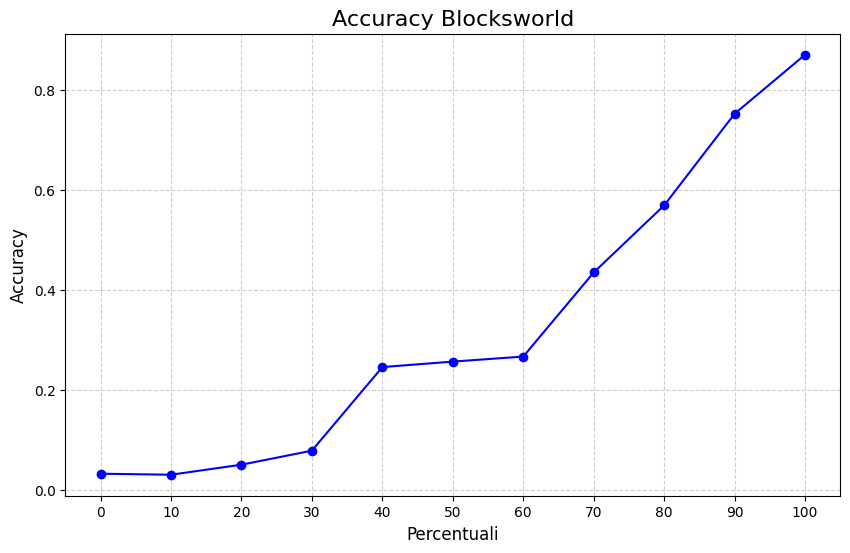

[0.033, 0.031, 0.051, 0.079, 0.246, 0.257, 0.267, 0.435, 0.569, 0.752, 0.87]


In [26]:
percentuali = []
risultati = [0,0,0,0,0,0,0,0,0,0,0]

for results in all_results:
    
    if len(percentuali)<1:
        percentuali = [dato['percentage'] for dato in results]              
    risultato = [dato['result'] for dato in results]     
    
    risultati = [x + y for x, y in zip(risultati, risultato)]  

risultati= [round(x / 100,3) for x in risultati]

plt.figure(figsize=(10, 6))
plt.plot(percentuali, risultati, marker='o', linestyle='-', color='b')

plt.title('Accuracy Blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()  

print(risultati)
        
        

## analisi degli errori

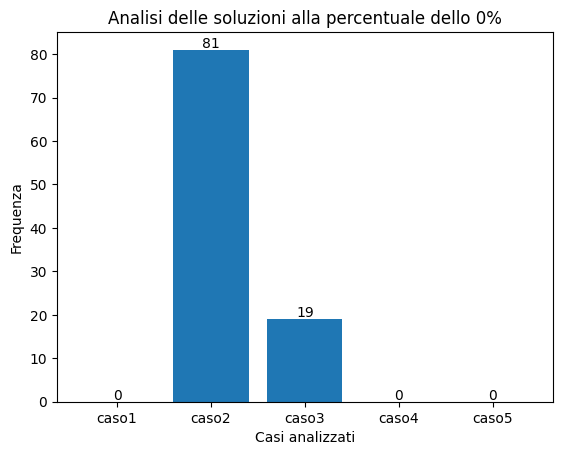

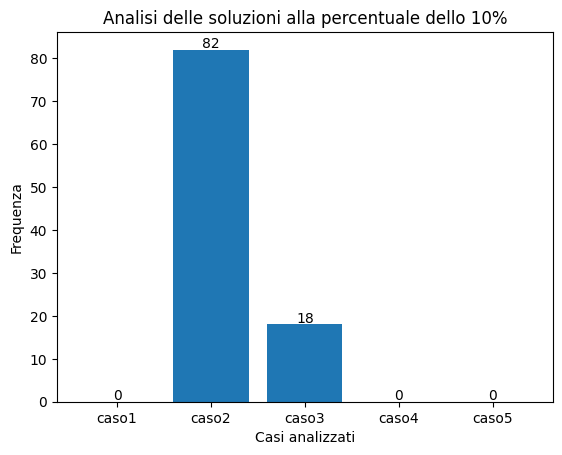

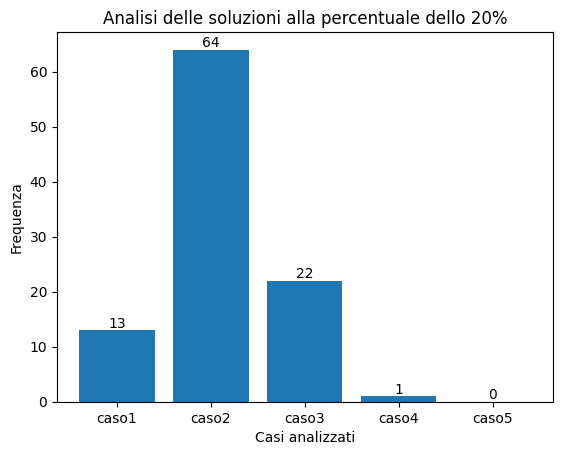

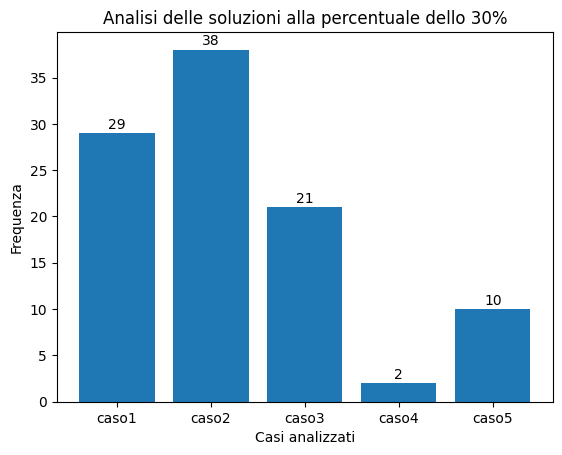

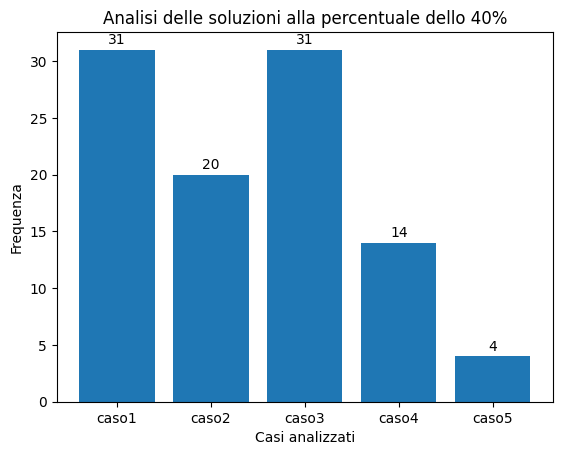

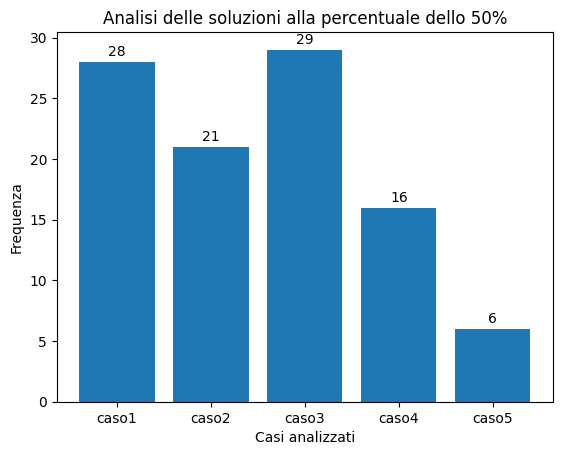

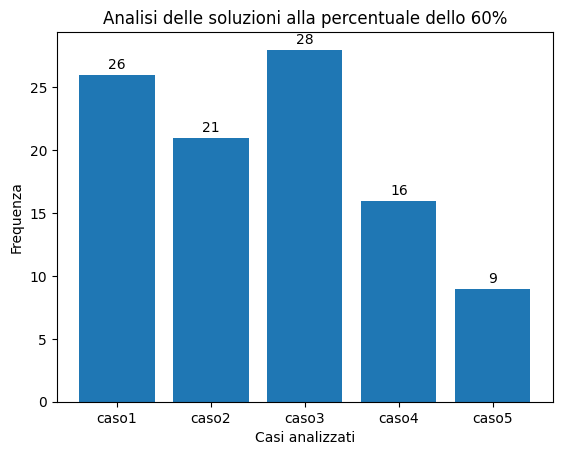

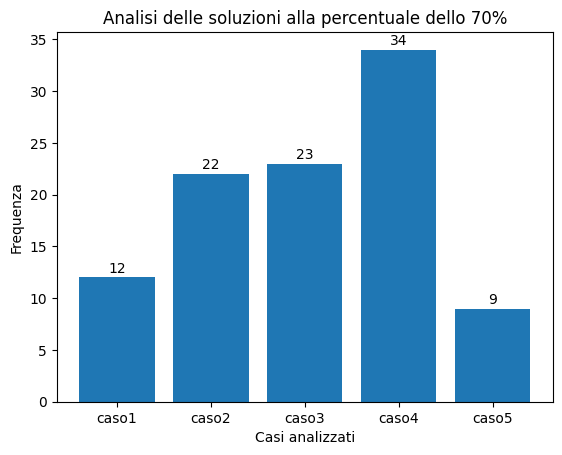

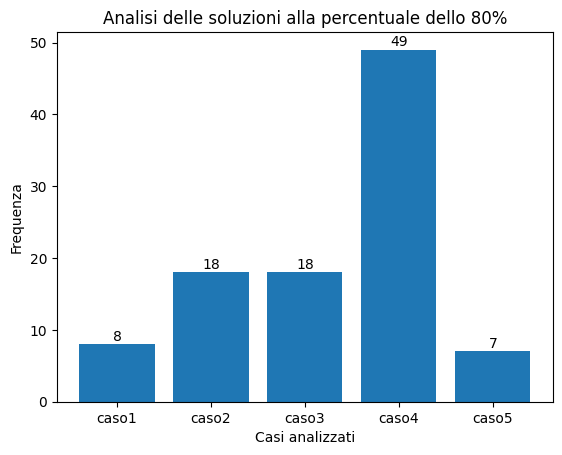

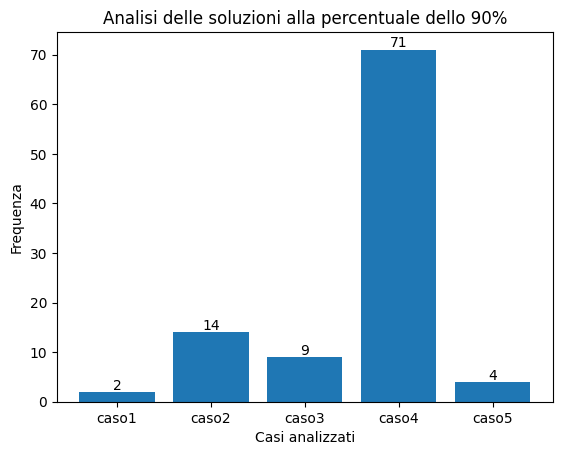

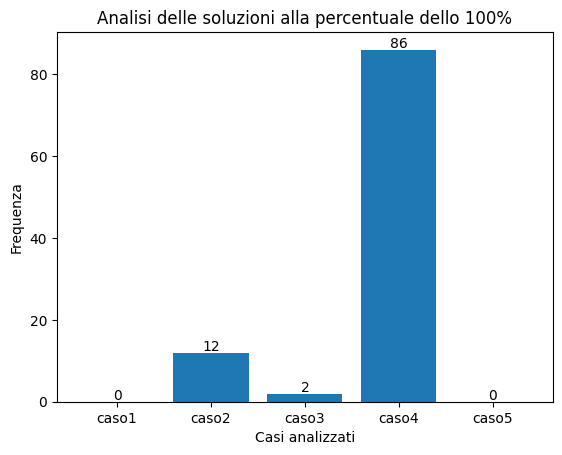

In [27]:
percentuali = {}
for percentage in all_results:
    for p in percentage:        
        if p['percentage'] not in percentuali:
            percentuali[p['percentage']] = {'caso1': 0, 'caso2': 0, 'caso3': 0, 'caso4': 0, 'caso5':0}
        if 'caso1' in p:
            percentuali[p['percentage']]['caso1'] += 1
        if 'caso2' in p:
            percentuali[p['percentage']]['caso2'] += 1
        if 'caso3' in p:
            percentuali[p['percentage']]['caso3'] += 1
        if 'caso4' in p:
            percentuali[p['percentage']]['caso4'] += 1  
        if 'caso5' in p:
            percentuali[p['percentage']]['caso5'] += 1        
            
for percentage, casi in percentuali.items():
    plt.bar(casi.keys(), casi.values())
    plt.title(f'Analisi delle soluzioni alla percentuale dello {percentage}%')
    for i, v in enumerate(casi.values()):
        plt.text(i, v + 0.5, str(v), color='black', ha='center')
    plt.xlabel('Casi analizzati')
    plt.ylabel('Frequenza')
    plt.show()

## analisi soluzioni unica immagine

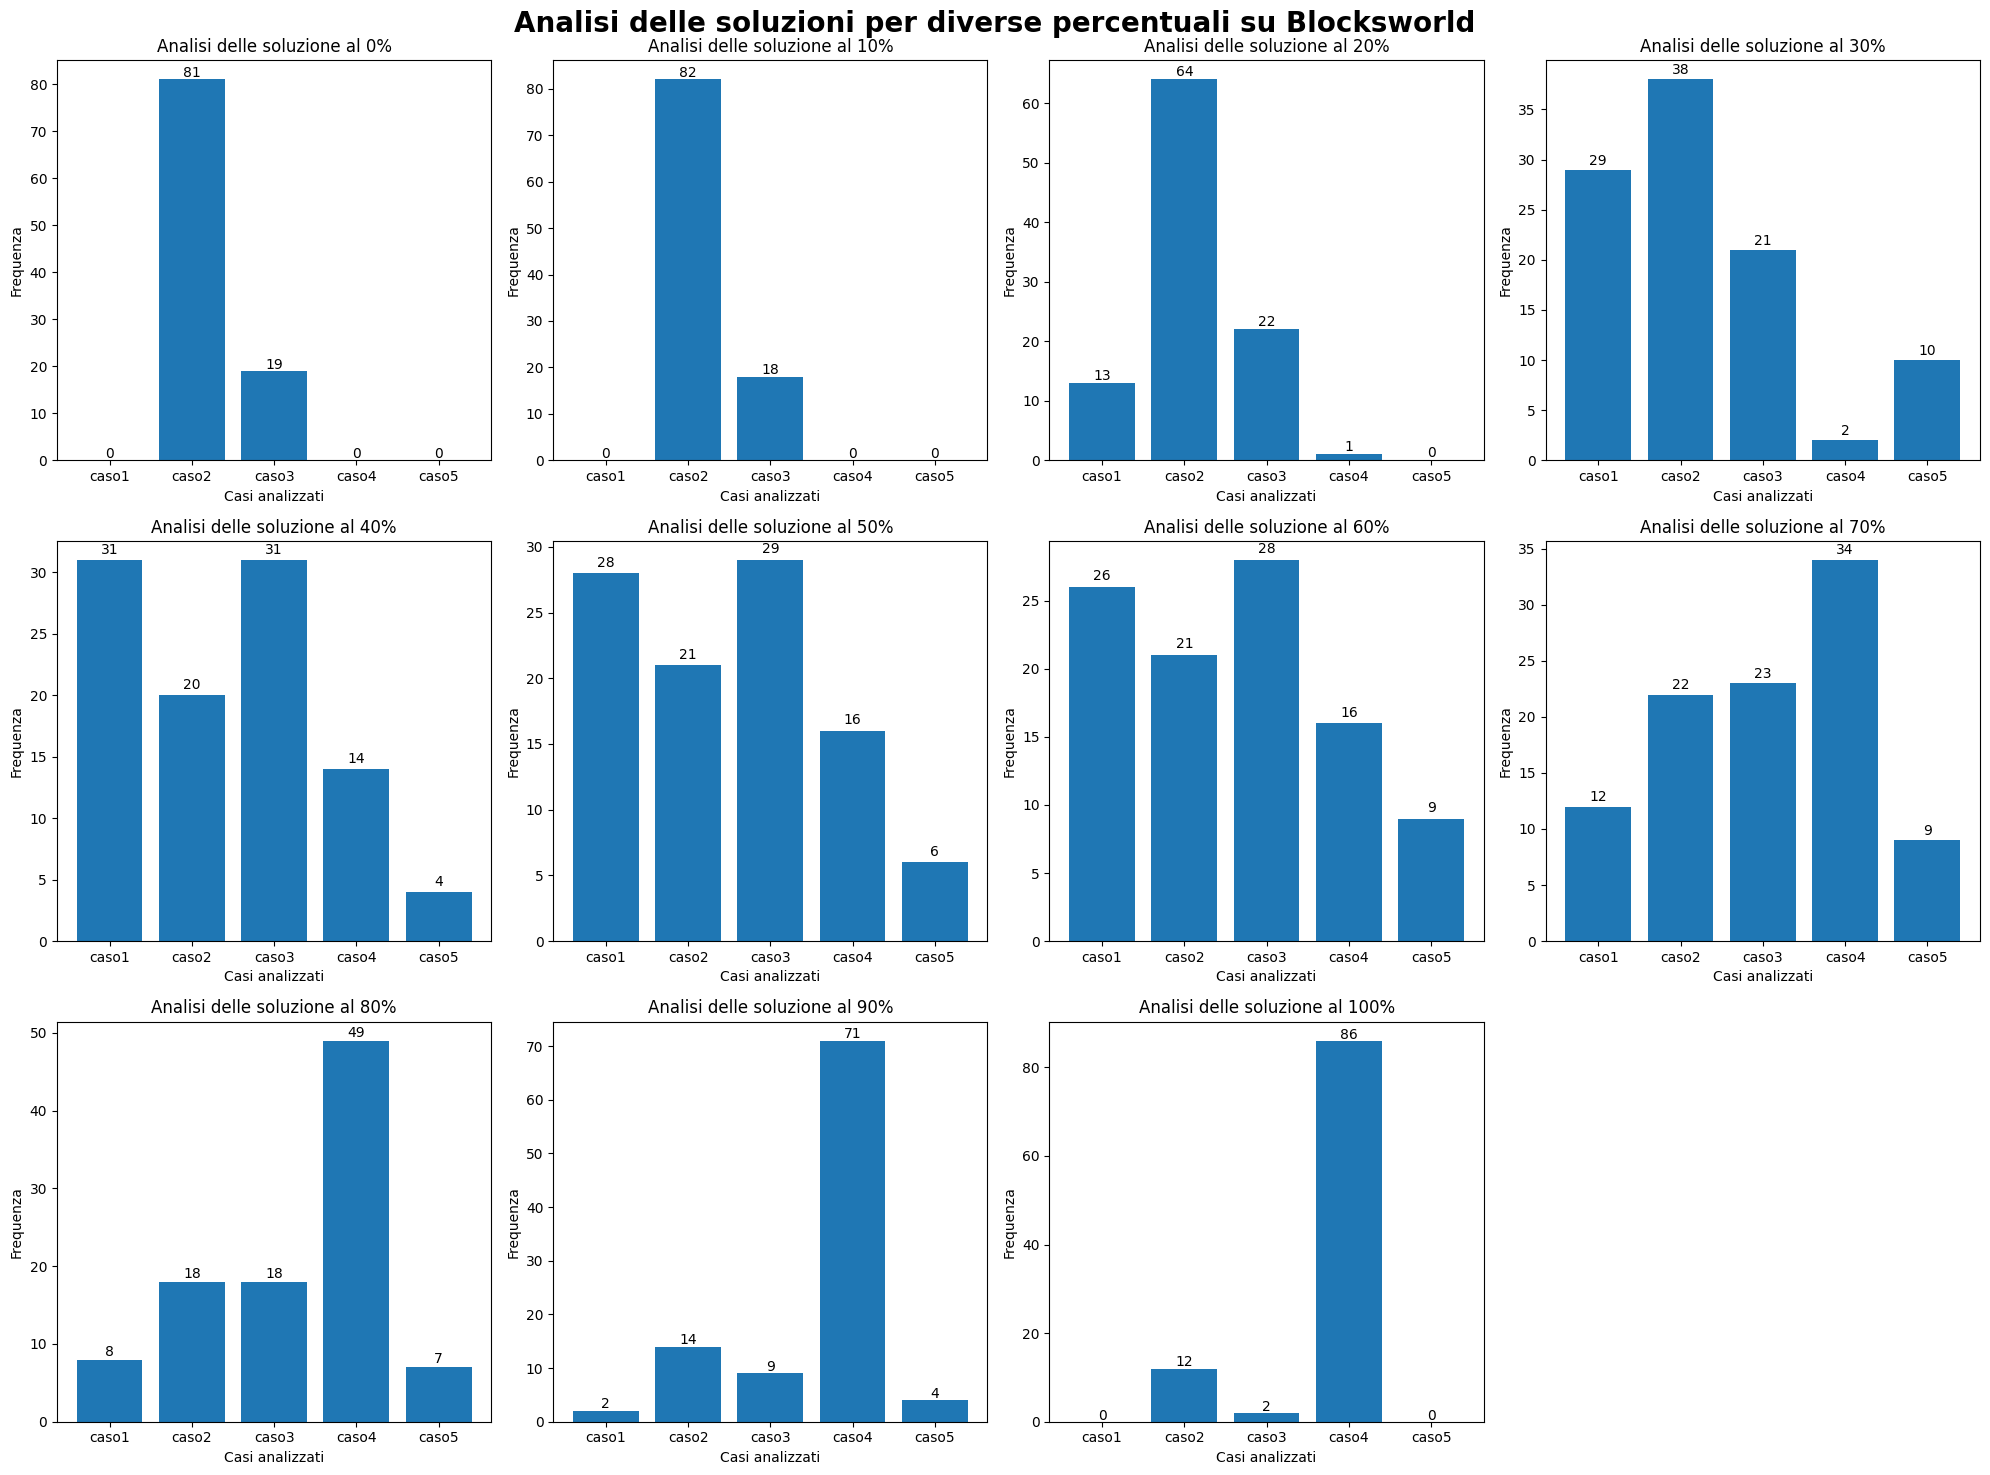

In [33]:
n_plots = len(percentuali)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su Blocksworld', fontsize=20, fontweight='bold')

for i, (percentage, casi) in enumerate(percentuali.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi.keys(), casi.values())
    ax.set_title(f'Analisi delle soluzione al {percentage}%')
    for j, v in enumerate(casi.values()):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

# metrica: maggior numero di goals soddisfatti

## RF e CV

In [4]:
List_RF = []
List_CV = []
v=0
all_results = []

for problem_data in grafics_data:    
    percentage = []
    v+=1
    problem_name = problem_data['problem']
    #print(v, problem_name)
    goals = problem_data['goals']
    actions = goals[0]['actions']
    #print("numero azione ottime: ",len(actions))
    for k in range(11): 
        k= (k)*10         
        percentage.append(round((len(actions)/100)*k)-1)   
      
    for idx,x in enumerate(percentage):       
        if x==-1:
            percentage[idx]=0               
    #print("idx_perc: ",percentage)     
    RF=0
    CV=0
    perc=0
    results = []
    idx_true=-5    
    for i in actions: 
        #print("azione: ", i)       
        max_goals = -1000 
        indici_max_goals = []        
        
        for idx,goal in enumerate(goals):  
            
            if goal['true_goal']:
                idx_true = idx
              
            if max_goals == goal['num_goals_sodisfated'][i]:
                indici_max_goals.append(idx)  
                         
            if max_goals <goal['num_goals_sodisfated'][i]:
                max_goals = goal['num_goals_sodisfated'][i]
                indici_max_goals = []
                indici_max_goals.append(idx)    
        
        if idx_true in indici_max_goals: 
            RF += 1/len(indici_max_goals)
            CV += 1/(len(indici_max_goals))
            if i in percentage:
                if len(indici_max_goals)==1:                    
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1,"caso3": True})
                        perc+=10                        
                else:
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1/len(indici_max_goals),"caso2": True})
                        perc+=10                        
        else:            
            if i in percentage:                                                       
                for j in range(percentage.count(i)):                               
                    results.append({"percentage": perc, "result": 0, "caso1": True})
                    perc+=10       
            CV = 0                        
    
        #print(indice_minimo, idx_true)    
        #print("CV:", CV)
        #print("RF:", RF)   
    all_results.append(results)       
     
    RF = RF/len(actions)
    CV = CV/len(actions)
    #print("CV:", CV)
    #print("RF:", RF)    
    List_RF.append(RF)
    List_CV.append(CV)    
         
Media_RF = round(sum(List_RF)/len(List_RF),3)
Media_CV = round(sum(List_CV)/len(List_CV),3)
print("Media_RF: ", Media_RF)
print("Media_CV: ", Media_CV)

DS_RF = round(statistics.stdev(List_RF),3)
DS_CV = round(statistics.stdev(List_CV),3)
print("DeviazioneStandard_RF: ", DS_RF)
print("DeviazioneStandard_CV: ", DS_CV)

Media_RF:  0.276
Media_CV:  0.258
DeviazioneStandard_RF:  0.232
DeviazioneStandard_CV:  0.231


## accuracy

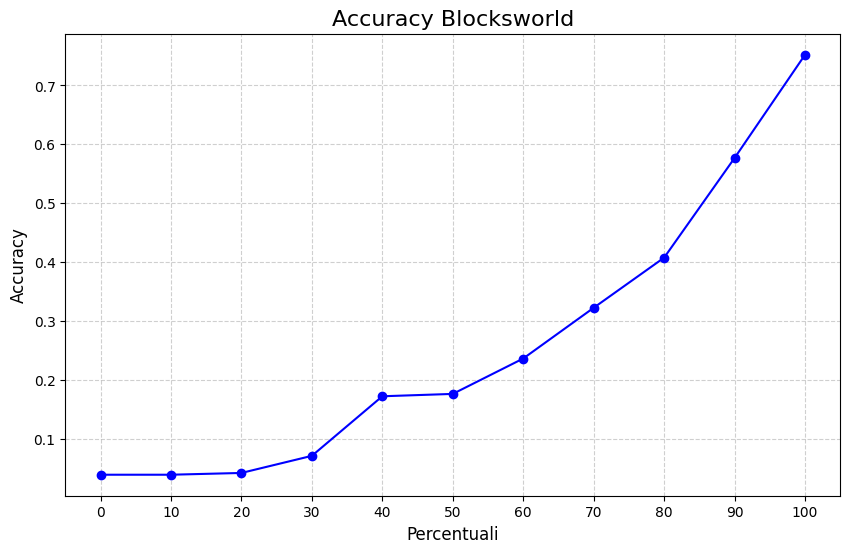

[0.04, 0.04, 0.043, 0.072, 0.173, 0.177, 0.237, 0.323, 0.408, 0.577, 0.752]


In [8]:
percentuali = []
risultati = [0,0,0,0,0,0,0,0,0,0,0]

for results in all_results:
    
    if len(percentuali)<1:
        percentuali = [dato['percentage'] for dato in results]              
    risultato = [dato['result'] for dato in results]     
    
    risultati = [x + y for x, y in zip(risultati, risultato)]  

risultati= [round(x / 100,3) for x in risultati]

plt.figure(figsize=(10, 6))
plt.plot(percentuali, risultati, marker='o', linestyle='-', color='b')

plt.title('Accuracy Blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()  

print(risultati)       
        

## analisi delle soluzioni

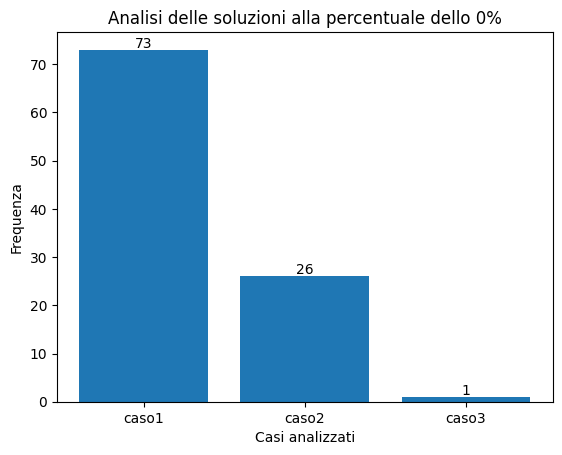

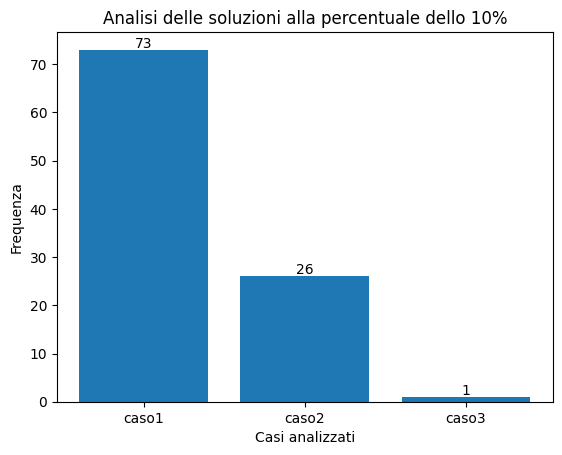

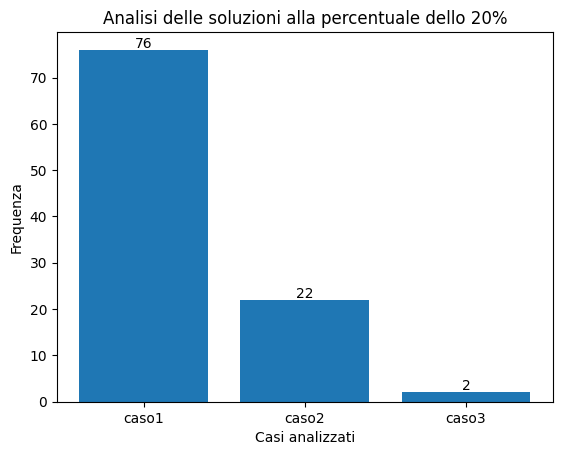

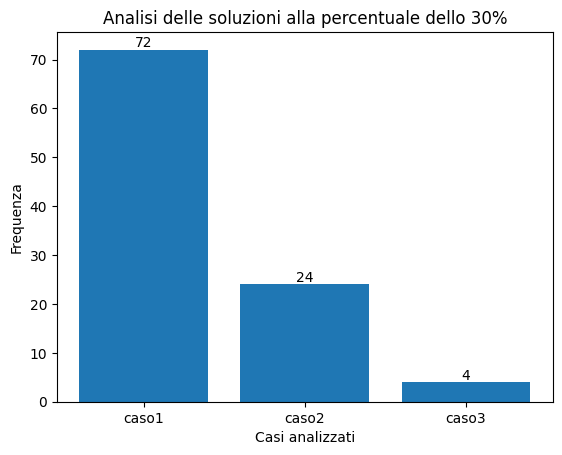

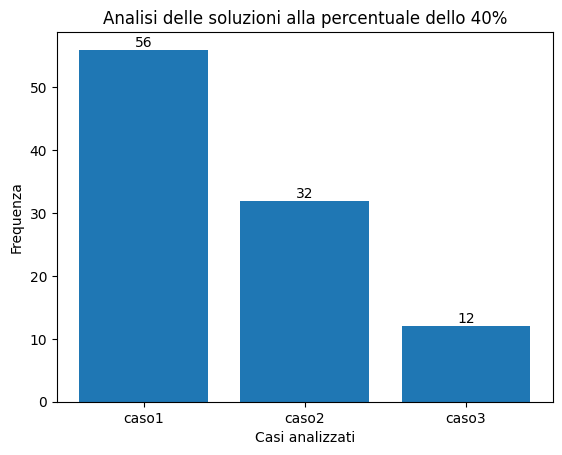

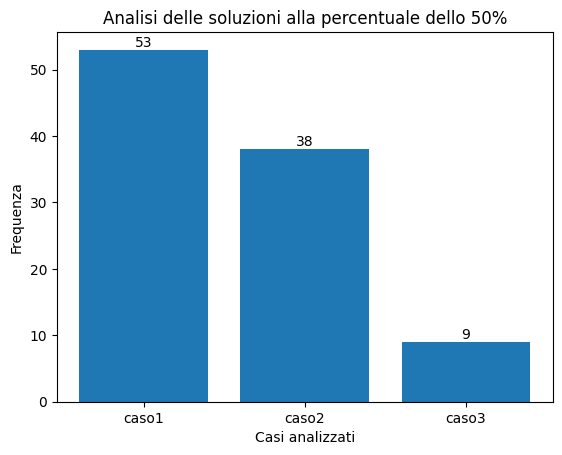

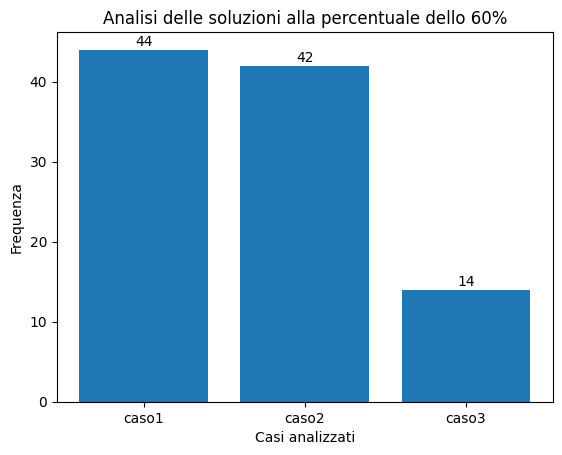

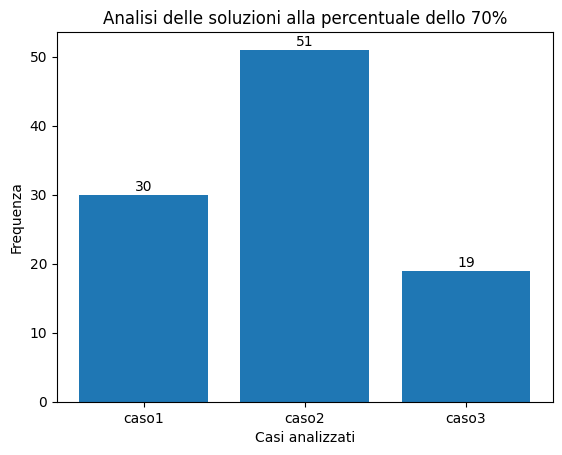

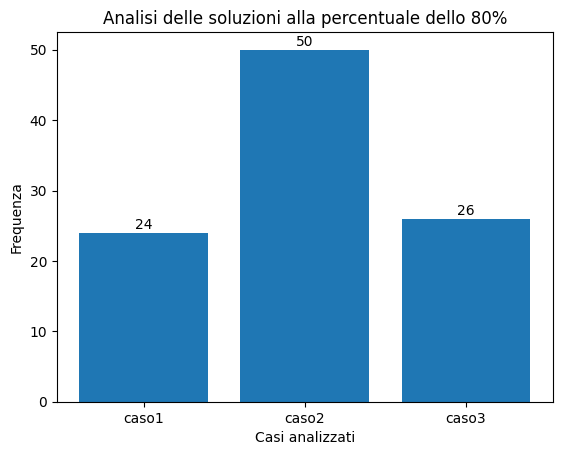

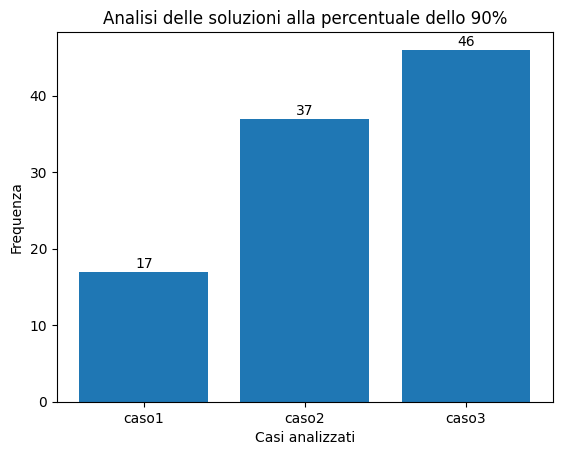

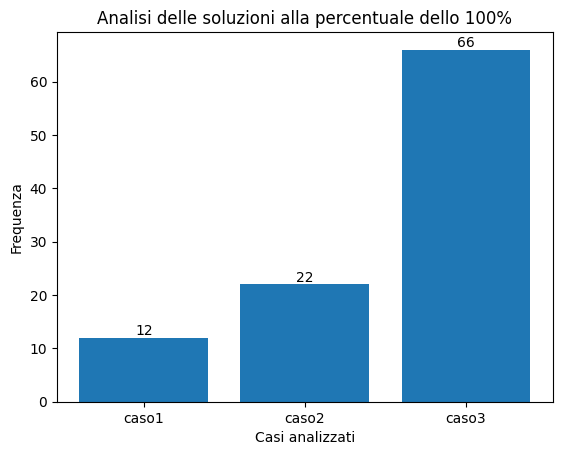

In [9]:
percentuali = {}
for percentage in all_results:
    for p in percentage:        
        if p['percentage'] not in percentuali:
            percentuali[p['percentage']] = {'caso1': 0, 'caso2': 0, 'caso3': 0}
        if 'caso1' in p:
            percentuali[p['percentage']]['caso1'] += 1
        if 'caso2' in p:
            percentuali[p['percentage']]['caso2'] += 1
        if 'caso3' in p:
            percentuali[p['percentage']]['caso3'] += 1               
            
for percentage, casi in percentuali.items():
    plt.bar(casi.keys(), casi.values())
    plt.title(f'Analisi delle soluzioni alla percentuale dello {percentage}%')
    for i, v in enumerate(casi.values()):
        plt.text(i, v + 0.5, str(v), color='black', ha='center')
    plt.xlabel('Casi analizzati')
    plt.ylabel('Frequenza')
    plt.show()

## analisi soluzioni unica immagine

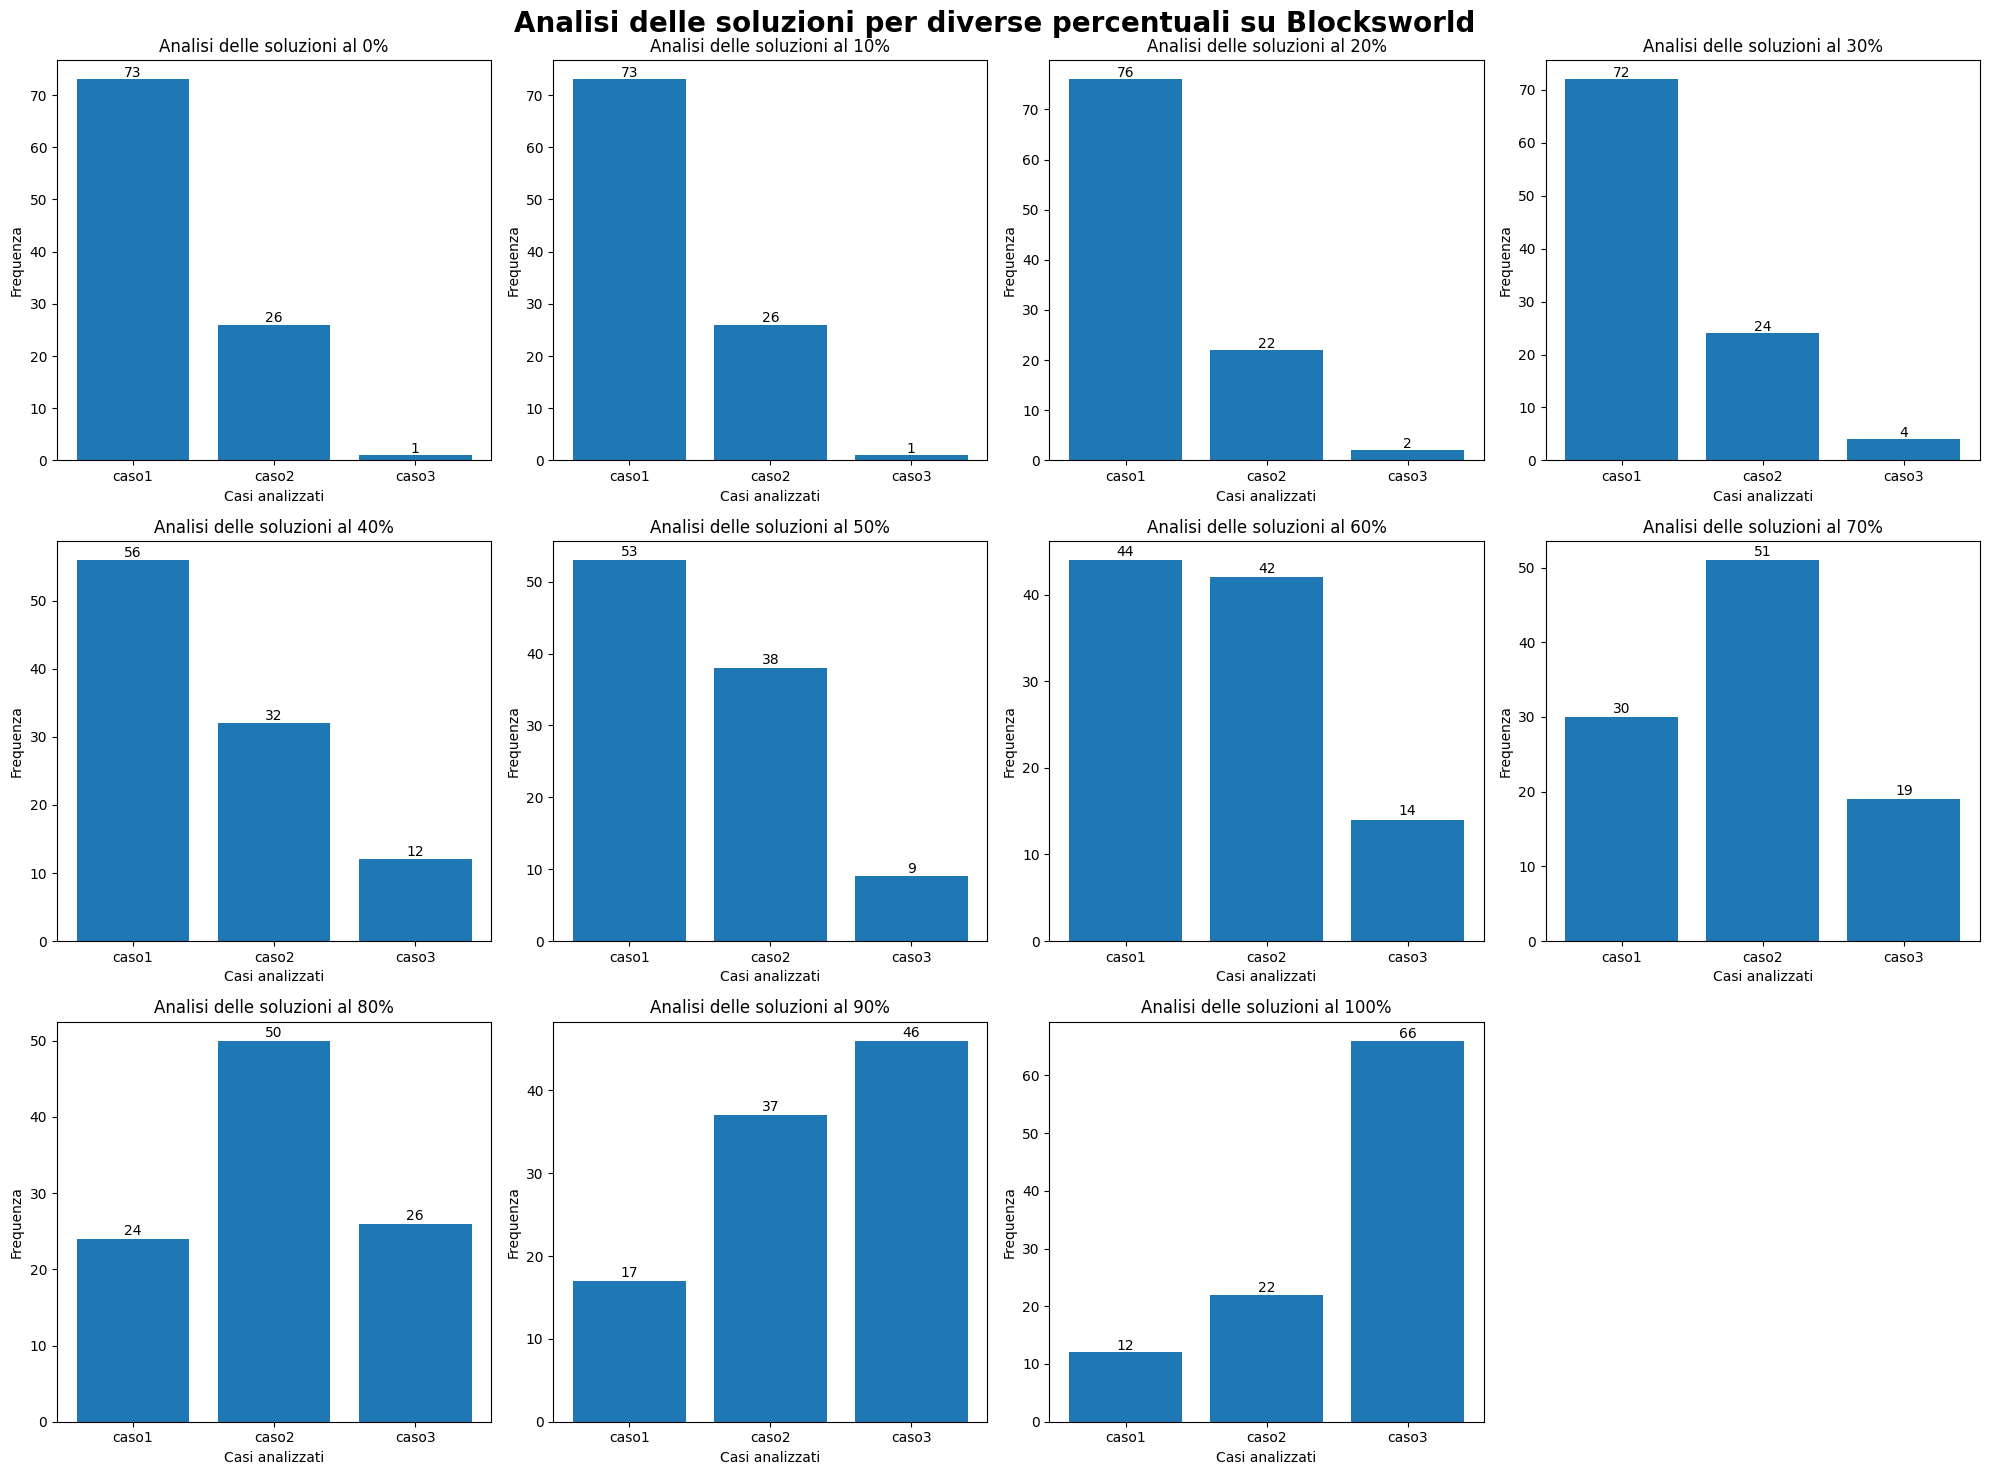

In [11]:
n_plots = len(percentuali)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su Blocksworld', fontsize=20, fontweight='bold')

for i, (percentage, casi) in enumerate(percentuali.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi.keys(), casi.values())
    ax.set_title(f'Analisi delle soluzioni al {percentage}%')
    for j, v in enumerate(casi.values()):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

# metrica: reward calcolata come: (numero goal soddisfatti / numero totali dei goals) (- 1)*    *se check_violated_preconditions

## RF e CV

In [15]:
List_RF = []
List_CV = []
v=0
all_results = []

for problem_data in grafics_data:    
    percentage = []
    v+=1
    problem_name = problem_data['problem']
    #print(v, problem_name)
    goals = problem_data['goals']
    actions = goals[0]['actions']
    #print("numero azione ottime: ",len(actions))
    for k in range(11): 
        k= (k)*10         
        percentage.append(round((len(actions)/100)*k)-1)   
      
    for idx,x in enumerate(percentage):       
        if x==-1:
            percentage[idx]=0               
    #print("idx_perc: ",percentage)     
    RF=0
    CV=0
    perc=0
    results = []
    idx_true=-5    
    for i in actions: 
        #print("azione: ", i)       
        max_reward = -1000 
        indici_max_reward = []        
        
        for idx,goal in enumerate(goals):  
            
            if goal['true_goal']:
                idx_true = idx
              
            if max_reward == goal['rewards'][i]:
                indici_max_reward.append(idx)  
                         
            if max_reward < goal['rewards'][i]:
                max_reward = goal['rewards'][i]
                indici_max_reward = []
                indici_max_reward.append(idx)    
        
        if idx_true in indici_max_reward: 
            RF += 1/len(indici_max_reward)
            CV += 1/(len(indici_max_reward))
            if i in percentage:
                if len(indici_max_reward)==1:                    
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1,"caso3": True})
                        perc+=10                        
                else:
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1/len(indici_max_reward),"caso2": True})
                        perc+=10                        
        else:            
            if i in percentage:                                                       
                for j in range(percentage.count(i)):                               
                    results.append({"percentage": perc, "result": 0, "caso1": True})
                    perc+=10       
            CV = 0                        
    
        #print(indici_max_reward, idx_true)    
        #print("CV:", CV)
        #print("RF:", RF)   
    all_results.append(results)       
     
    RF = RF/len(actions)
    CV = CV/len(actions)
    #print("CV:", CV)
    #print("RF:", RF)    
    List_RF.append(RF)
    List_CV.append(CV)    
         
Media_RF = round(sum(List_RF)/len(List_RF),3)
Media_CV = round(sum(List_CV)/len(List_CV),3)
print("Media_RF: ", Media_RF)
print("Media_CV: ", Media_CV)

DS_RF = round(statistics.stdev(List_RF),3)
DS_CV = round(statistics.stdev(List_CV),3)
print("DeviazioneStandard_RF: ", DS_RF)
print("DeviazioneStandard_CV: ", DS_CV)


Media_RF:  0.293
Media_CV:  0.265
DeviazioneStandard_RF:  0.18
DeviazioneStandard_CV:  0.184


## accuracy

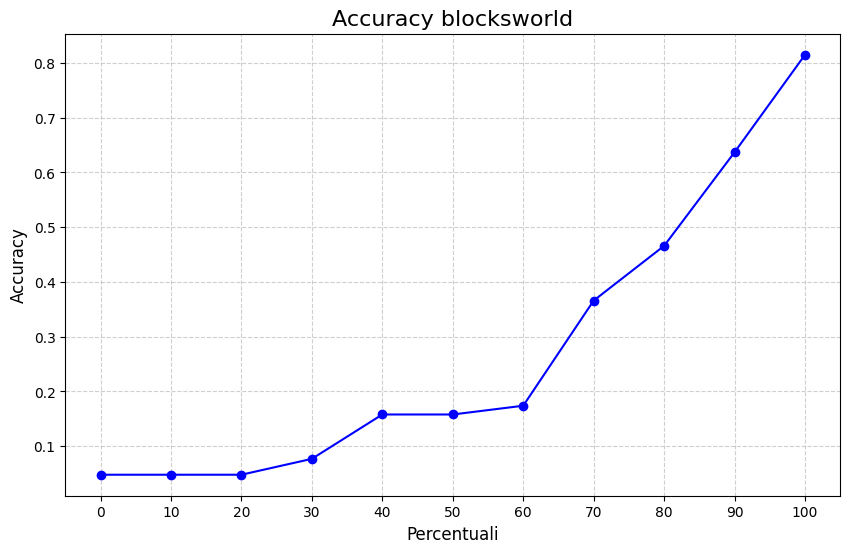

[0.048, 0.048, 0.048, 0.077, 0.158, 0.158, 0.174, 0.366, 0.466, 0.637, 0.815]


In [16]:
percentuali = []
risultati = [0,0,0,0,0,0,0,0,0,0,0]

for results in all_results:
    
    if len(percentuali)<1:
        percentuali = [dato['percentage'] for dato in results]              
    risultato = [dato['result'] for dato in results]     
    
    risultati = [x + y for x, y in zip(risultati, risultato)]  

risultati= [round(x / 100,3) for x in risultati]

plt.figure(figsize=(10, 6))
plt.plot(percentuali, risultati, marker='o', linestyle='-', color='b')

plt.title('Accuracy blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()  

print(risultati)       
        

## analisi delle soluzioni

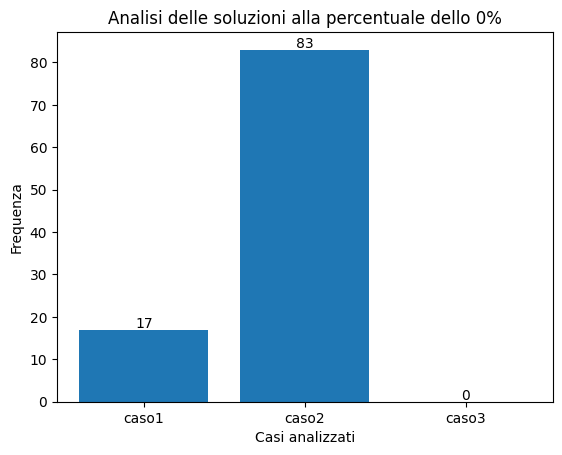

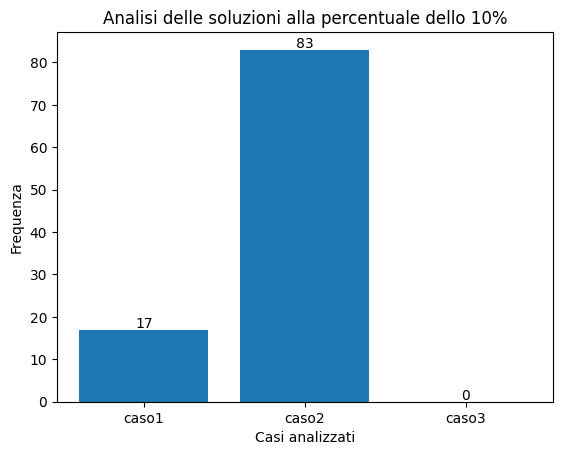

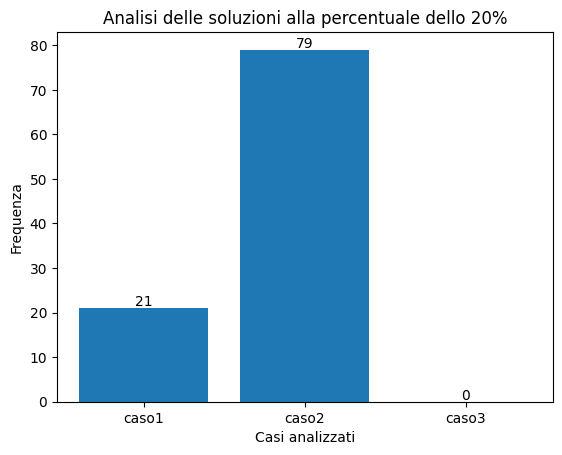

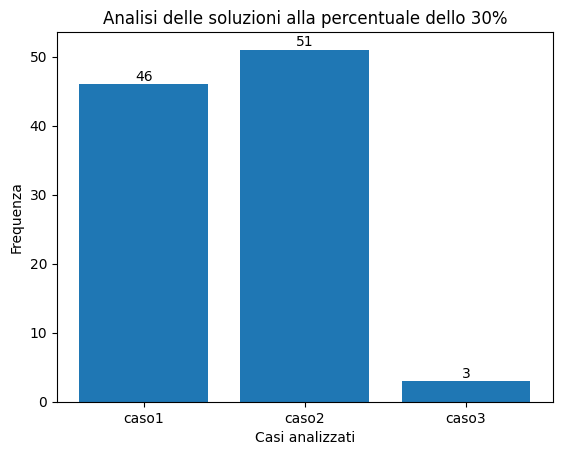

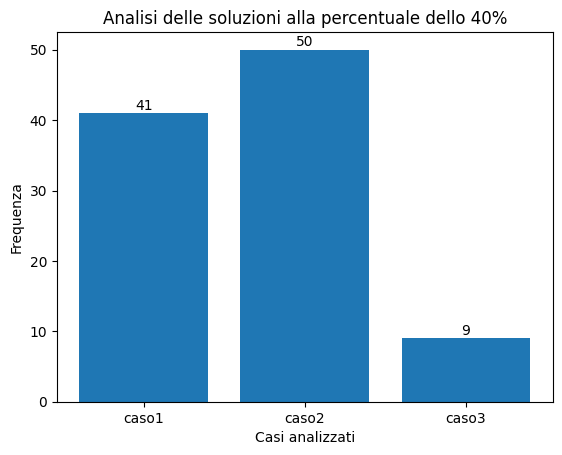

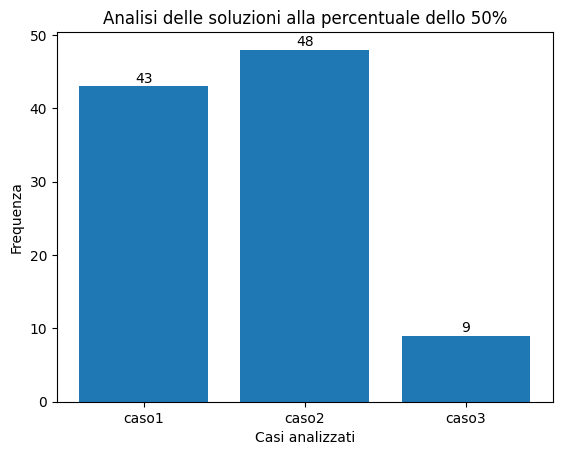

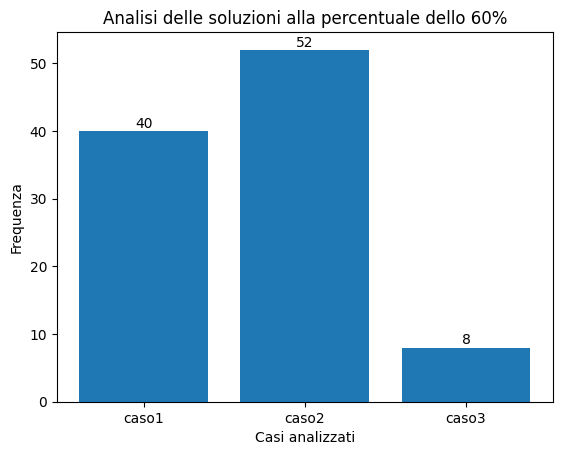

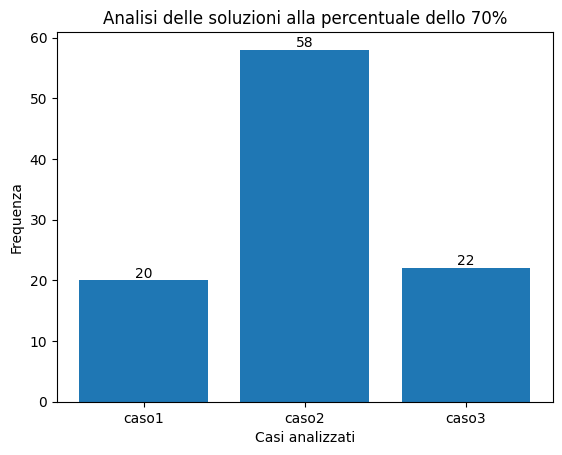

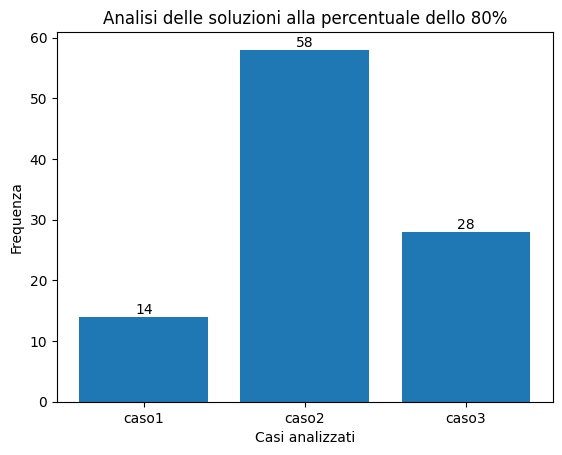

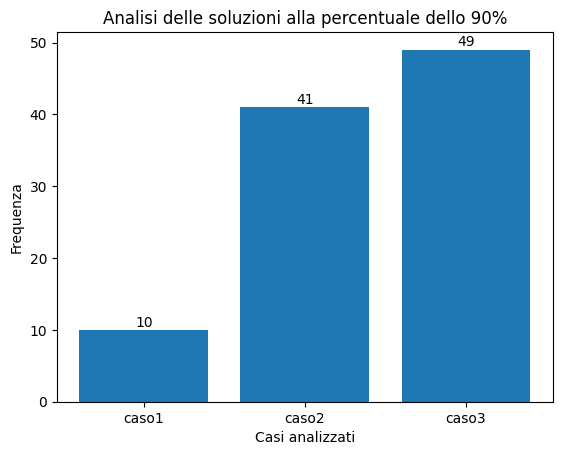

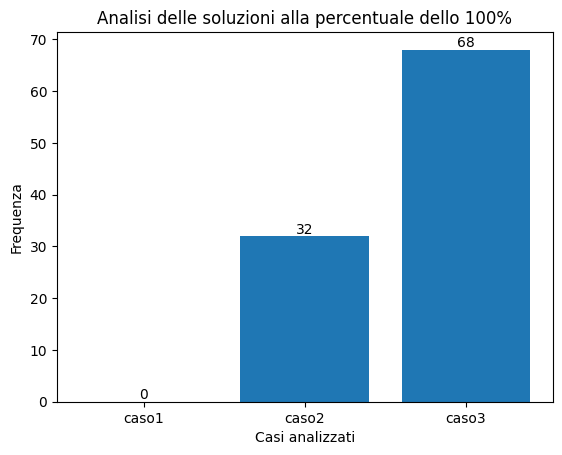

In [17]:
percentuali = {}
for percentage in all_results:
    for p in percentage:        
        if p['percentage'] not in percentuali:
            percentuali[p['percentage']] = {'caso1': 0, 'caso2': 0, 'caso3': 0}
        if 'caso1' in p:
            percentuali[p['percentage']]['caso1'] += 1
        if 'caso2' in p:
            percentuali[p['percentage']]['caso2'] += 1
        if 'caso3' in p:
            percentuali[p['percentage']]['caso3'] += 1               
            
for percentage, casi in percentuali.items():
    plt.bar(casi.keys(), casi.values())
    plt.title(f'Analisi delle soluzioni alla percentuale dello {percentage}%')
    for i, v in enumerate(casi.values()):
        plt.text(i, v + 0.5, str(v), color='black', ha='center')
    plt.xlabel('Casi analizzati')
    plt.ylabel('Frequenza')
    plt.show()

## analisi soluzioni unica immagine

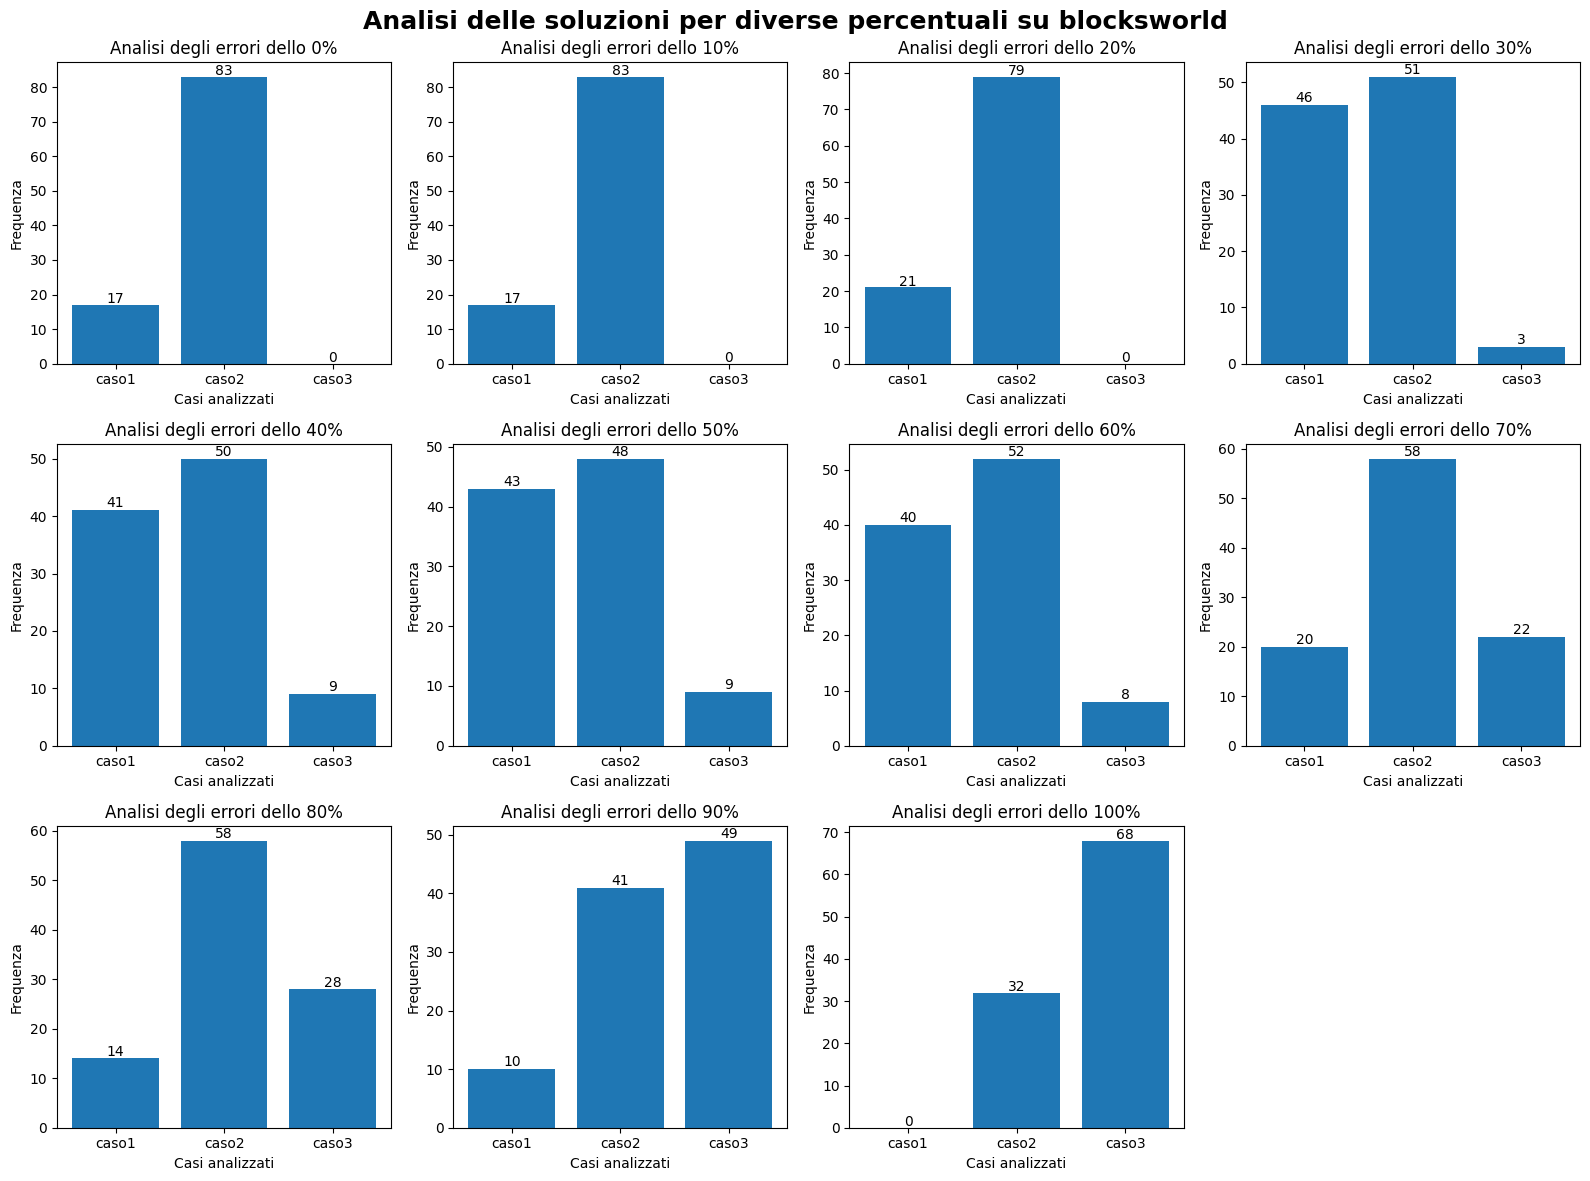

In [18]:
n_plots = len(percentuali)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su blocksworld', fontsize=18, fontweight='bold')

for i, (percentage, casi) in enumerate(percentuali.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi.keys(), casi.values())
    ax.set_title(f'Analisi degli errori dello {percentage}%')
    for j, v in enumerate(casi.values()):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

# metrica: calcola il numero di goal soddisfatti ma penalizzando sulla lunghezza (no_penality = false)

## RF e CV

In [66]:
List_RF = []
List_CV = []
v=0
all_results = []

for problem_data in grafics_data:    
    percentage = []
    v+=1
    problem_name = problem_data['problem']
    #print(v, problem_name)
    goals = problem_data['goals']
    actions = goals[0]['actions']
    #print("numero azione ottime: ",len(actions))
    for k in range(11): 
        k= (k)*10         
        percentage.append(round((len(actions)/100)*k)-1)   
      
    for idx,x in enumerate(percentage):       
        if x==-1:
            percentage[idx]=0               
    #print("idx_perc: ",percentage)     
    RF=0
    CV=0
    perc=0
    results = []
    idx_true=-5    
    for i in actions: 
        #print("azione: ", i)       
        max_reward = -1000 
        indici_max_reward = []        
        
        for idx,goal in enumerate(goals):  
            
            if goal['true_goal']:
                idx_true = idx
              
            if max_reward == goal['metric_new_false'][i]:
                indici_max_reward.append(idx)  
                         
            if max_reward < goal['metric_new_false'][i]:
                max_reward = goal['metric_new_false'][i]
                indici_max_reward = []
                indici_max_reward.append(idx)    
        
        if idx_true in indici_max_reward: 
            RF += 1/len(indici_max_reward)
            CV += 1/(len(indici_max_reward))
            if i in percentage:
                if len(indici_max_reward)==1:                    
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1,"caso3": True})
                        perc+=10                        
                else:
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1/len(indici_max_reward),"caso2": True})
                        perc+=10                        
        else:            
            if i in percentage:                                                       
                for j in range(percentage.count(i)):                               
                    results.append({"percentage": perc, "result": 0, "caso1": True})
                    perc+=10       
            CV = 0                        
    
        #print(indici_max_reward, idx_true)    
        #print("CV:", CV)
        #print("RF:", RF)   
    all_results.append(results)       
     
    RF = RF/len(actions)
    CV = CV/len(actions)
    #print("CV:", CV)
    #print("RF:", RF)    
    List_RF.append(RF)
    List_CV.append(CV)    
         
Media_RF = round(sum(List_RF)/len(List_RF),3)
Media_CV = round(sum(List_CV)/len(List_CV),3)
print("Media_RF: ", Media_RF)
print("Media_CV: ", Media_CV)

DS_RF = round(statistics.stdev(List_RF),3)
DS_CV = round(statistics.stdev(List_CV),3)
print("DeviazioneStandard_RF: ", DS_RF)
print("DeviazioneStandard_CV: ", DS_CV)



Media_RF:  0.151
Media_CV:  0.093
DeviazioneStandard_RF:  0.232
DeviazioneStandard_CV:  0.218


## accuracy

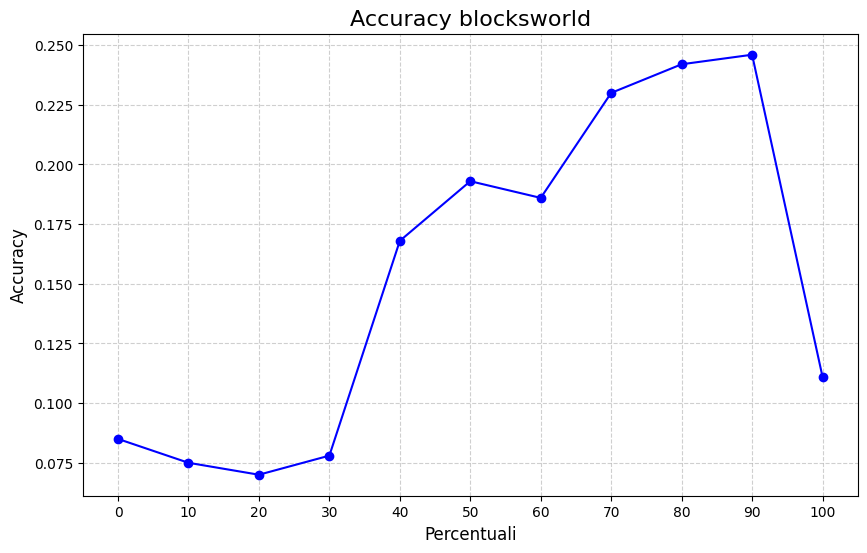

[0.085, 0.075, 0.07, 0.078, 0.168, 0.193, 0.186, 0.23, 0.242, 0.246, 0.111]


In [67]:
percentuali = []
risultati = [0,0,0,0,0,0,0,0,0,0,0]

for results in all_results:
    
    if len(percentuali)<1:
        percentuali = [dato['percentage'] for dato in results]              
    risultato = [dato['result'] for dato in results]     
    
    risultati = [x + y for x, y in zip(risultati, risultato)]  

risultati= [round(x / 100,3) for x in risultati]

plt.figure(figsize=(10, 6))
plt.plot(percentuali, risultati, marker='o', linestyle='-', color='b')

plt.title('Accuracy blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()  

print(risultati)       
        

## analisi delle soluzioni

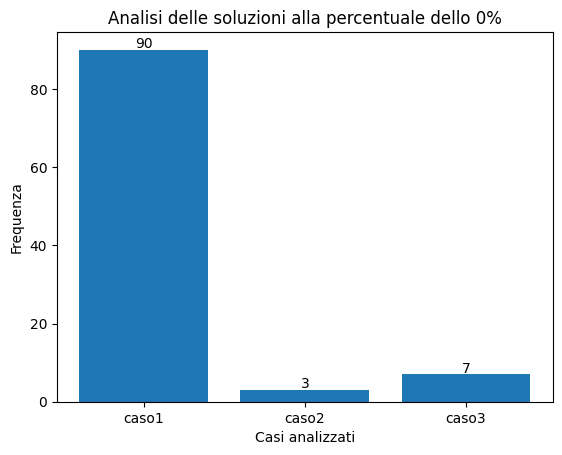

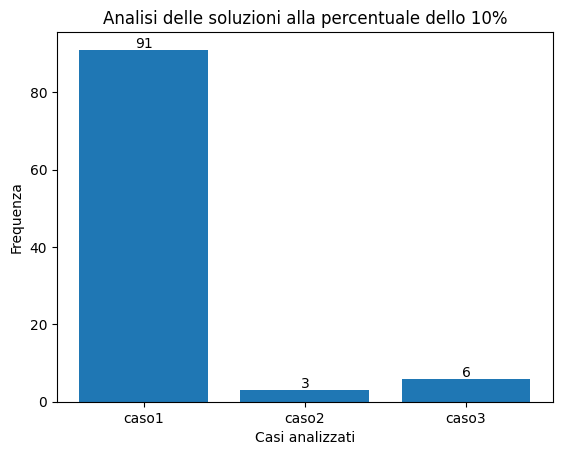

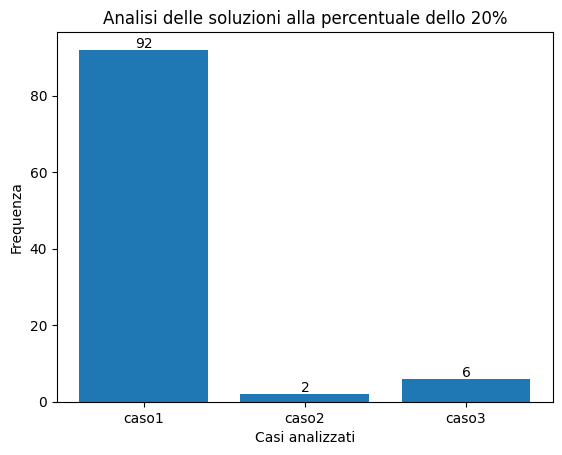

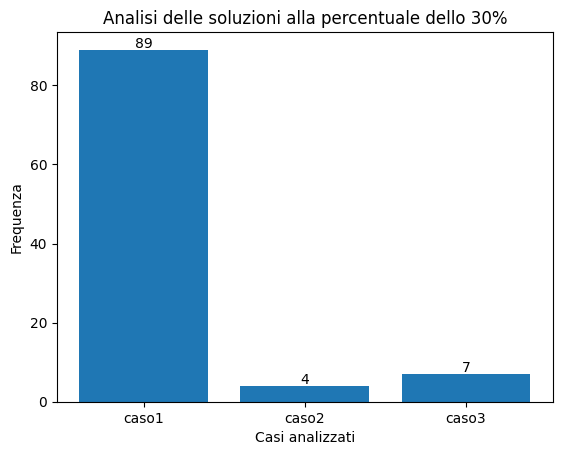

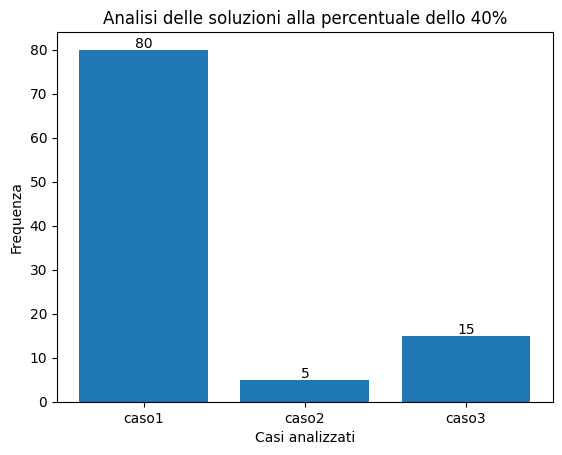

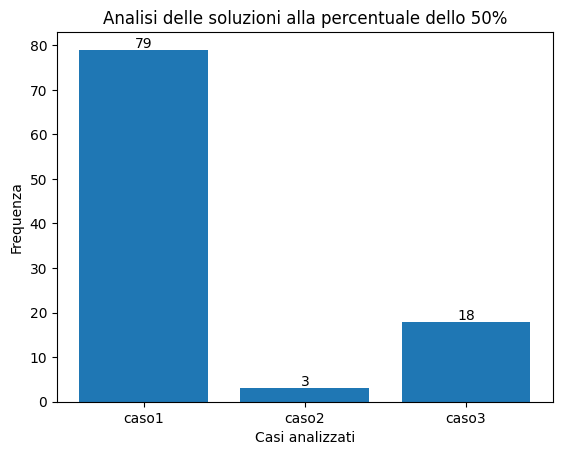

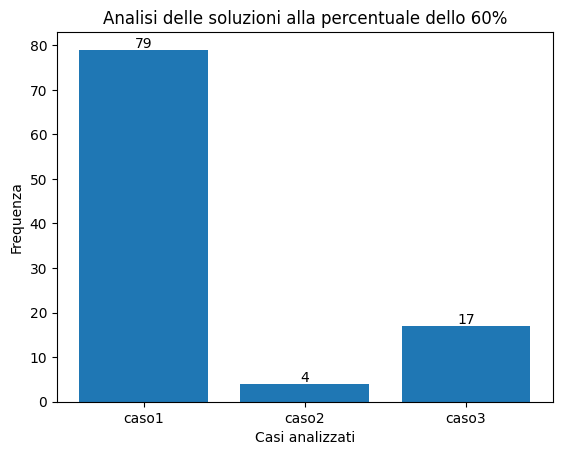

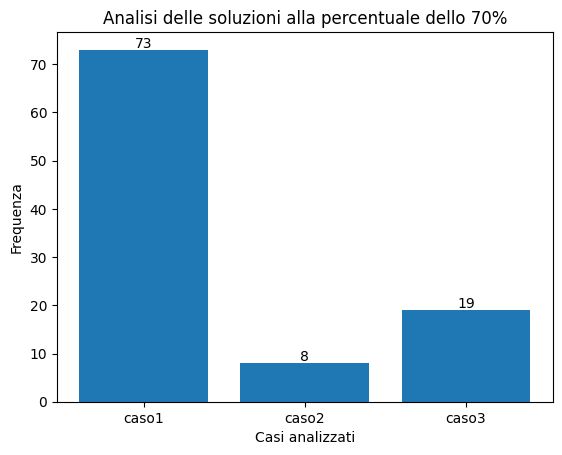

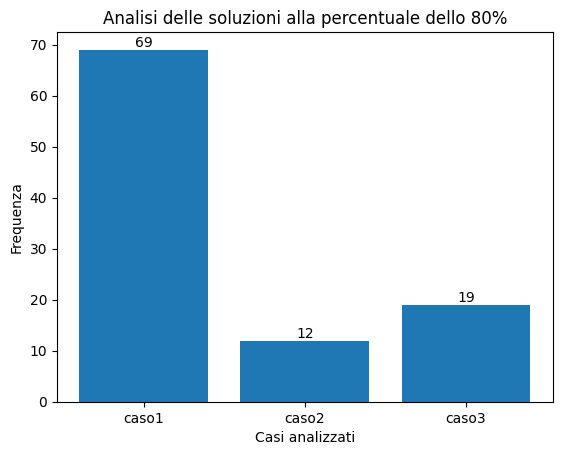

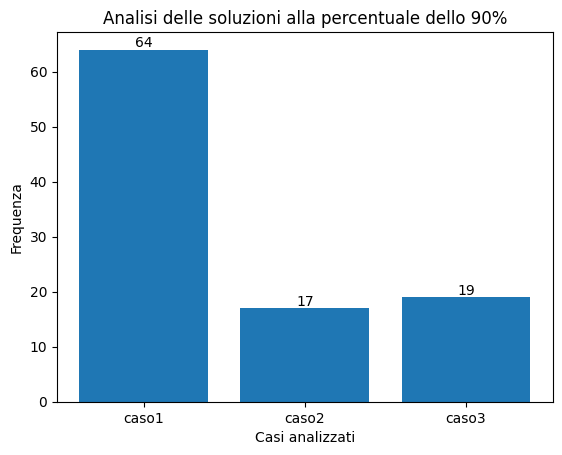

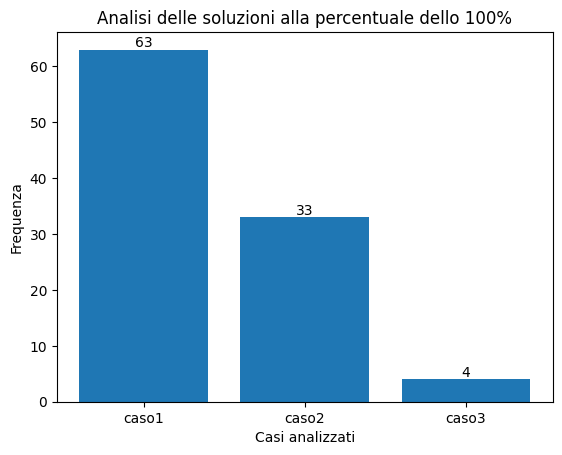

In [68]:
percentuali = {}
for percentage in all_results:
    for p in percentage:        
        if p['percentage'] not in percentuali:
            percentuali[p['percentage']] = {'caso1': 0, 'caso2': 0, 'caso3': 0}
        if 'caso1' in p:
            percentuali[p['percentage']]['caso1'] += 1
        if 'caso2' in p:
            percentuali[p['percentage']]['caso2'] += 1
        if 'caso3' in p:
            percentuali[p['percentage']]['caso3'] += 1               
            
for percentage, casi in percentuali.items():
    plt.bar(casi.keys(), casi.values())
    plt.title(f'Analisi delle soluzioni alla percentuale dello {percentage}%')
    for i, v in enumerate(casi.values()):
        plt.text(i, v + 0.5, str(v), color='black', ha='center')
    plt.xlabel('Casi analizzati')
    plt.ylabel('Frequenza')
    plt.show()

## analisi soluzioni unica immagine

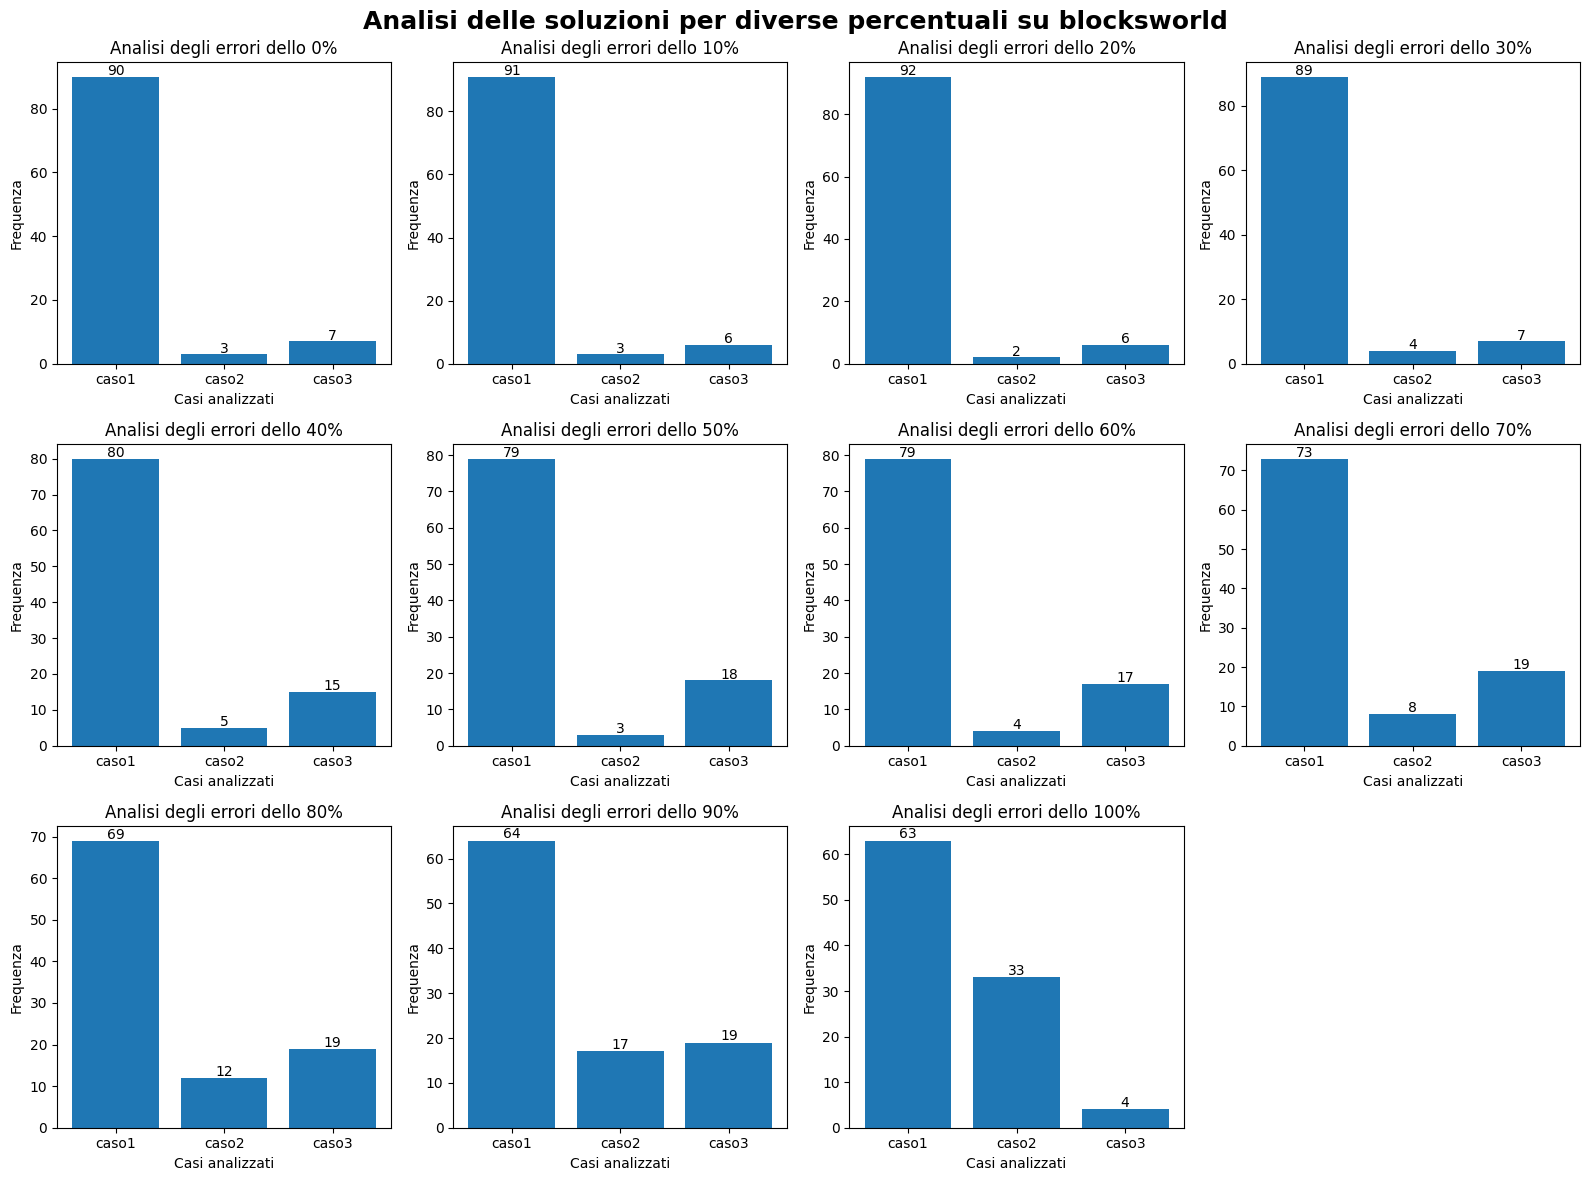

In [69]:
n_plots = len(percentuali)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su blocksworld', fontsize=18, fontweight='bold')

for i, (percentage, casi) in enumerate(percentuali.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi.keys(), casi.values())
    ax.set_title(f'Analisi degli errori dello {percentage}%')
    for j, v in enumerate(casi.values()):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

# metrica: calcola il numero di goal soddisfatti ma penalizzando sulla lunghezza (no_penality = true)

## RF e CV

In [70]:
List_RF = []
List_CV = []
v=0
all_results = []

for problem_data in grafics_data:    
    percentage = []
    v+=1
    problem_name = problem_data['problem']
    #print(v, problem_name)
    goals = problem_data['goals']
    actions = goals[0]['actions']
    #print("numero azione ottime: ",len(actions))
    for k in range(11): 
        k= (k)*10         
        percentage.append(round((len(actions)/100)*k)-1)   
      
    for idx,x in enumerate(percentage):       
        if x==-1:
            percentage[idx]=0               
    #print("idx_perc: ",percentage)     
    RF=0
    CV=0
    perc=0
    results = []
    idx_true=-5    
    for i in actions: 
        #print("azione: ", i)       
        max_reward = -1000 
        indici_max_reward = []        
        
        for idx,goal in enumerate(goals):  
            
            if goal['true_goal']:
                idx_true = idx
              
            if max_reward == goal['metric_new_true'][i]:
                indici_max_reward.append(idx)  
                         
            if max_reward < goal['metric_new_true'][i]:                
                max_reward = goal['metric_new_true'][i]
                indici_max_reward = []
                indici_max_reward.append(idx)    
        
        if idx_true in indici_max_reward: 
            RF += 1/len(indici_max_reward)
            CV += 1/(len(indici_max_reward))
            if i in percentage:
                if len(indici_max_reward)==1:                    
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1,"caso3": True})
                        perc+=10                        
                else:
                    for j in range(percentage.count(i)):                                
                        results.append({"percentage": perc, "result": 1/len(indici_max_reward),"caso2": True})
                        perc+=10                        
        else:            
            if i in percentage:                                                       
                for j in range(percentage.count(i)):                               
                    results.append({"percentage": perc, "result": 0, "caso1": True})
                    perc+=10       
            CV = 0                        
    
        #print(indici_max_reward, idx_true)    
        #print("CV:", CV)
        #print("RF:", RF)   
    all_results.append(results)       
     
    RF = RF/len(actions)
    CV = CV/len(actions)
    #print("CV:", CV)
    #print("RF:", RF)    
    List_RF.append(RF)
    List_CV.append(CV)    
         
Media_RF = round(sum(List_RF)/len(List_RF),3)
Media_CV = round(sum(List_CV)/len(List_CV),3)
print("Media_RF: ", Media_RF)
print("Media_CV: ", Media_CV)

DS_RF = round(statistics.stdev(List_RF),3)
DS_CV = round(statistics.stdev(List_CV),3)
print("DeviazioneStandard_RF: ", DS_RF)
print("DeviazioneStandard_CV: ", DS_CV)



Media_RF:  0.087
Media_CV:  0.065
DeviazioneStandard_RF:  0.201
DeviazioneStandard_CV:  0.189


## accuracy

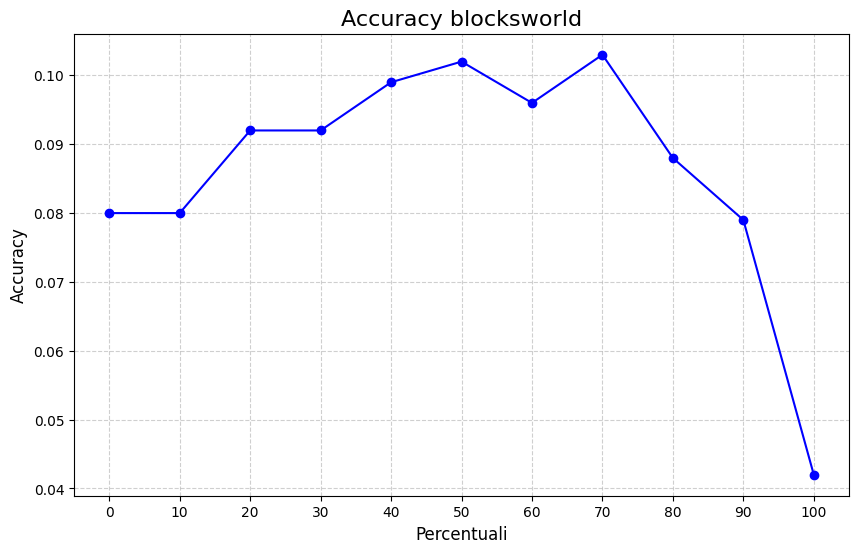

[0.08, 0.08, 0.092, 0.092, 0.099, 0.102, 0.096, 0.103, 0.088, 0.079, 0.042]


In [71]:
percentuali = []
risultati = [0,0,0,0,0,0,0,0,0,0,0]

for results in all_results:
    
    if len(percentuali)<1:
        percentuali = [dato['percentage'] for dato in results]              
    risultato = [dato['result'] for dato in results]     
    
    risultati = [x + y for x, y in zip(risultati, risultato)]  

risultati= [round(x / 100,3) for x in risultati]

plt.figure(figsize=(10, 6))
plt.plot(percentuali, risultati, marker='o', linestyle='-', color='b')

plt.title('Accuracy blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()  

print(risultati)
        
        

## analisi delle soluzioni

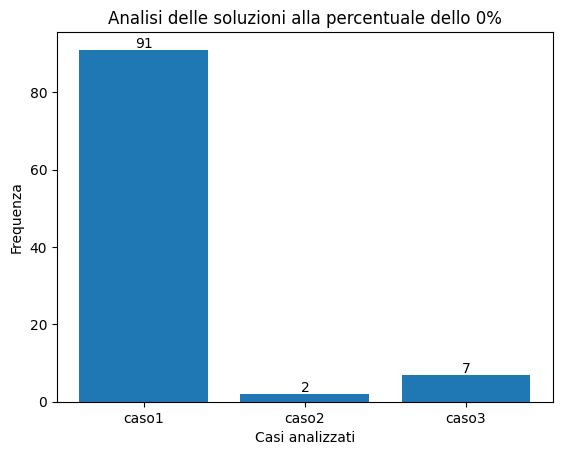

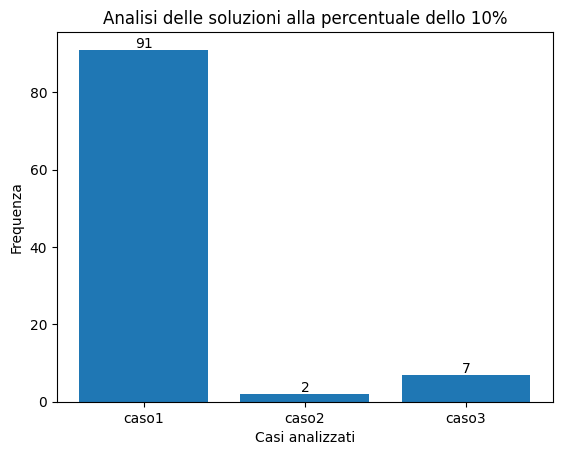

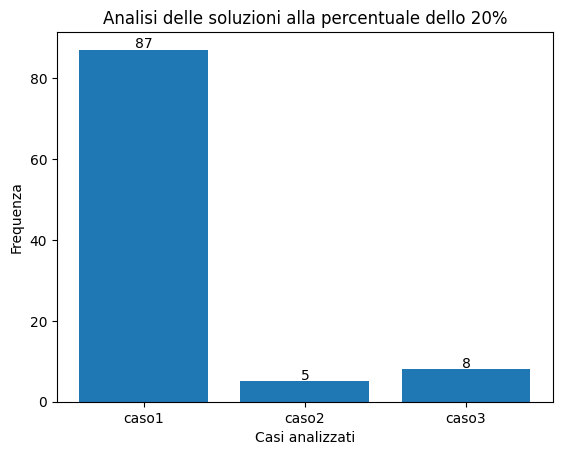

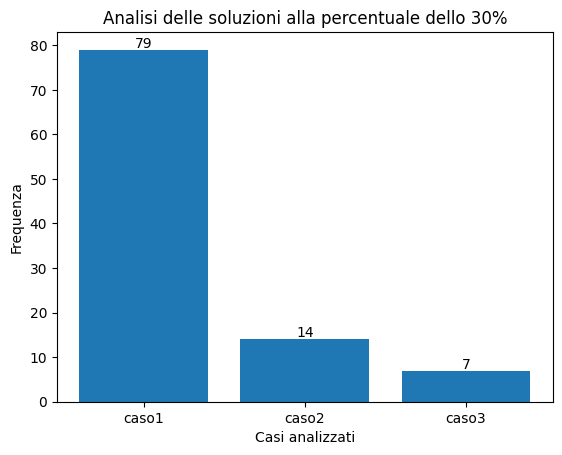

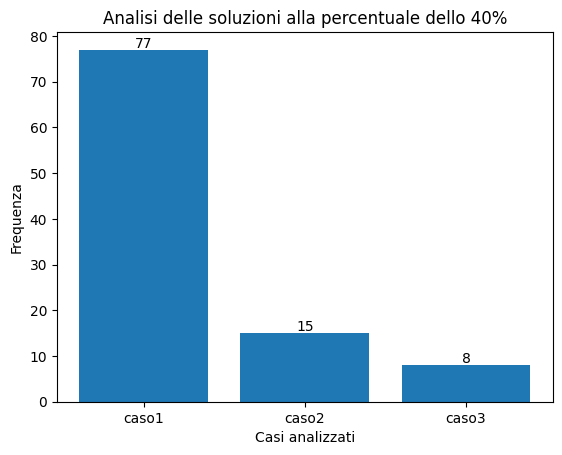

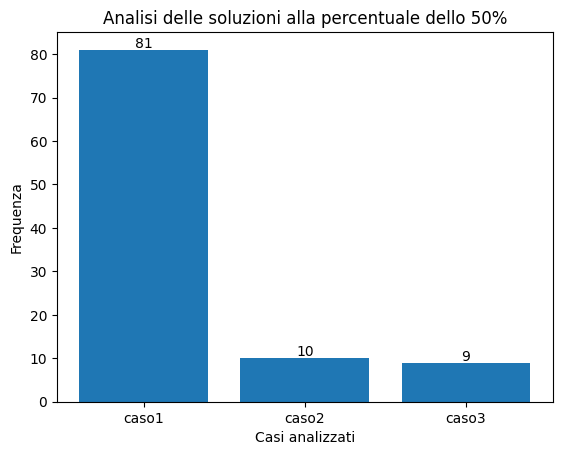

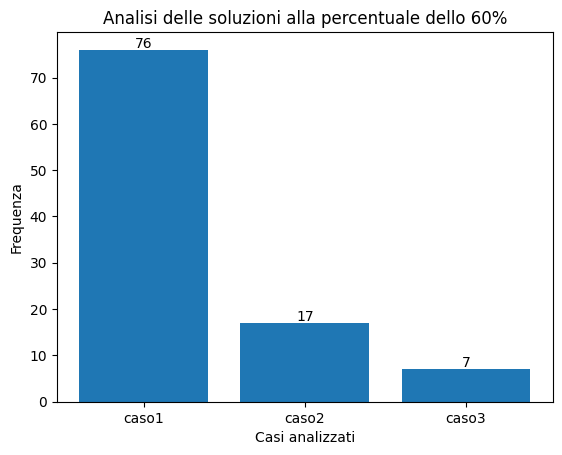

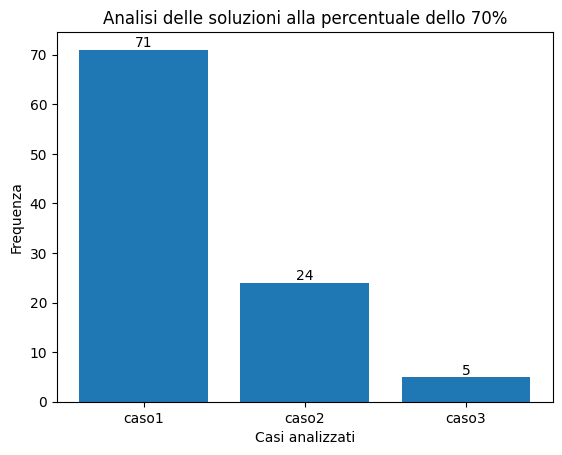

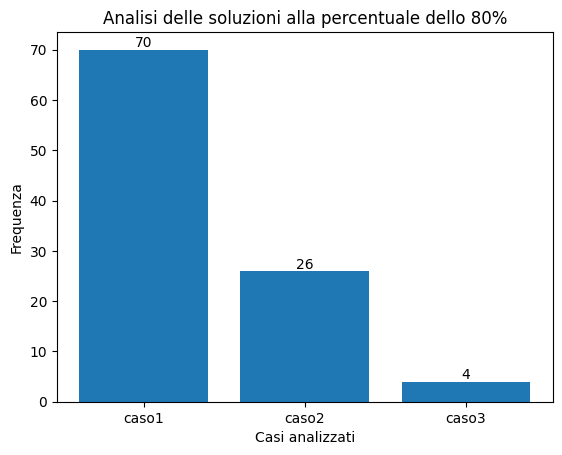

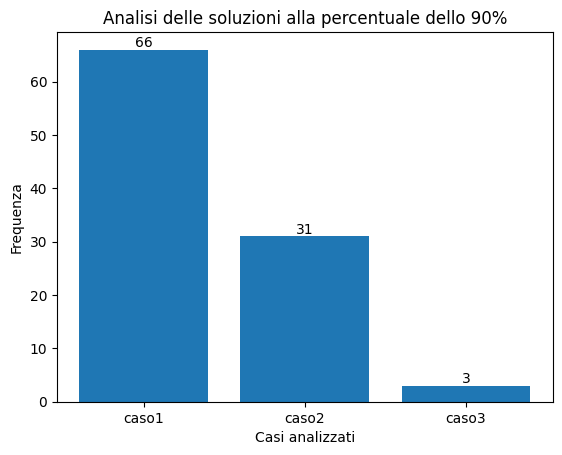

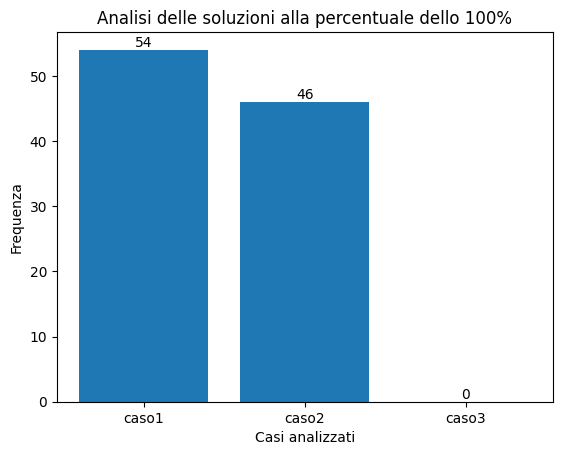

In [72]:
percentuali = {}
for percentage in all_results:
    for p in percentage:        
        if p['percentage'] not in percentuali:
            percentuali[p['percentage']] = {'caso1': 0, 'caso2': 0, 'caso3': 0}
        if 'caso1' in p:
            percentuali[p['percentage']]['caso1'] += 1
        if 'caso2' in p:
            percentuali[p['percentage']]['caso2'] += 1
        if 'caso3' in p:
            percentuali[p['percentage']]['caso3'] += 1               
            
for percentage, casi in percentuali.items():
    plt.bar(casi.keys(), casi.values())
    plt.title(f'Analisi delle soluzioni alla percentuale dello {percentage}%')
    for i, v in enumerate(casi.values()):
        plt.text(i, v + 0.5, str(v), color='black', ha='center')
    plt.xlabel('Casi analizzati')
    plt.ylabel('Frequenza')
    plt.show()

## analisi soluzioni unica immagine

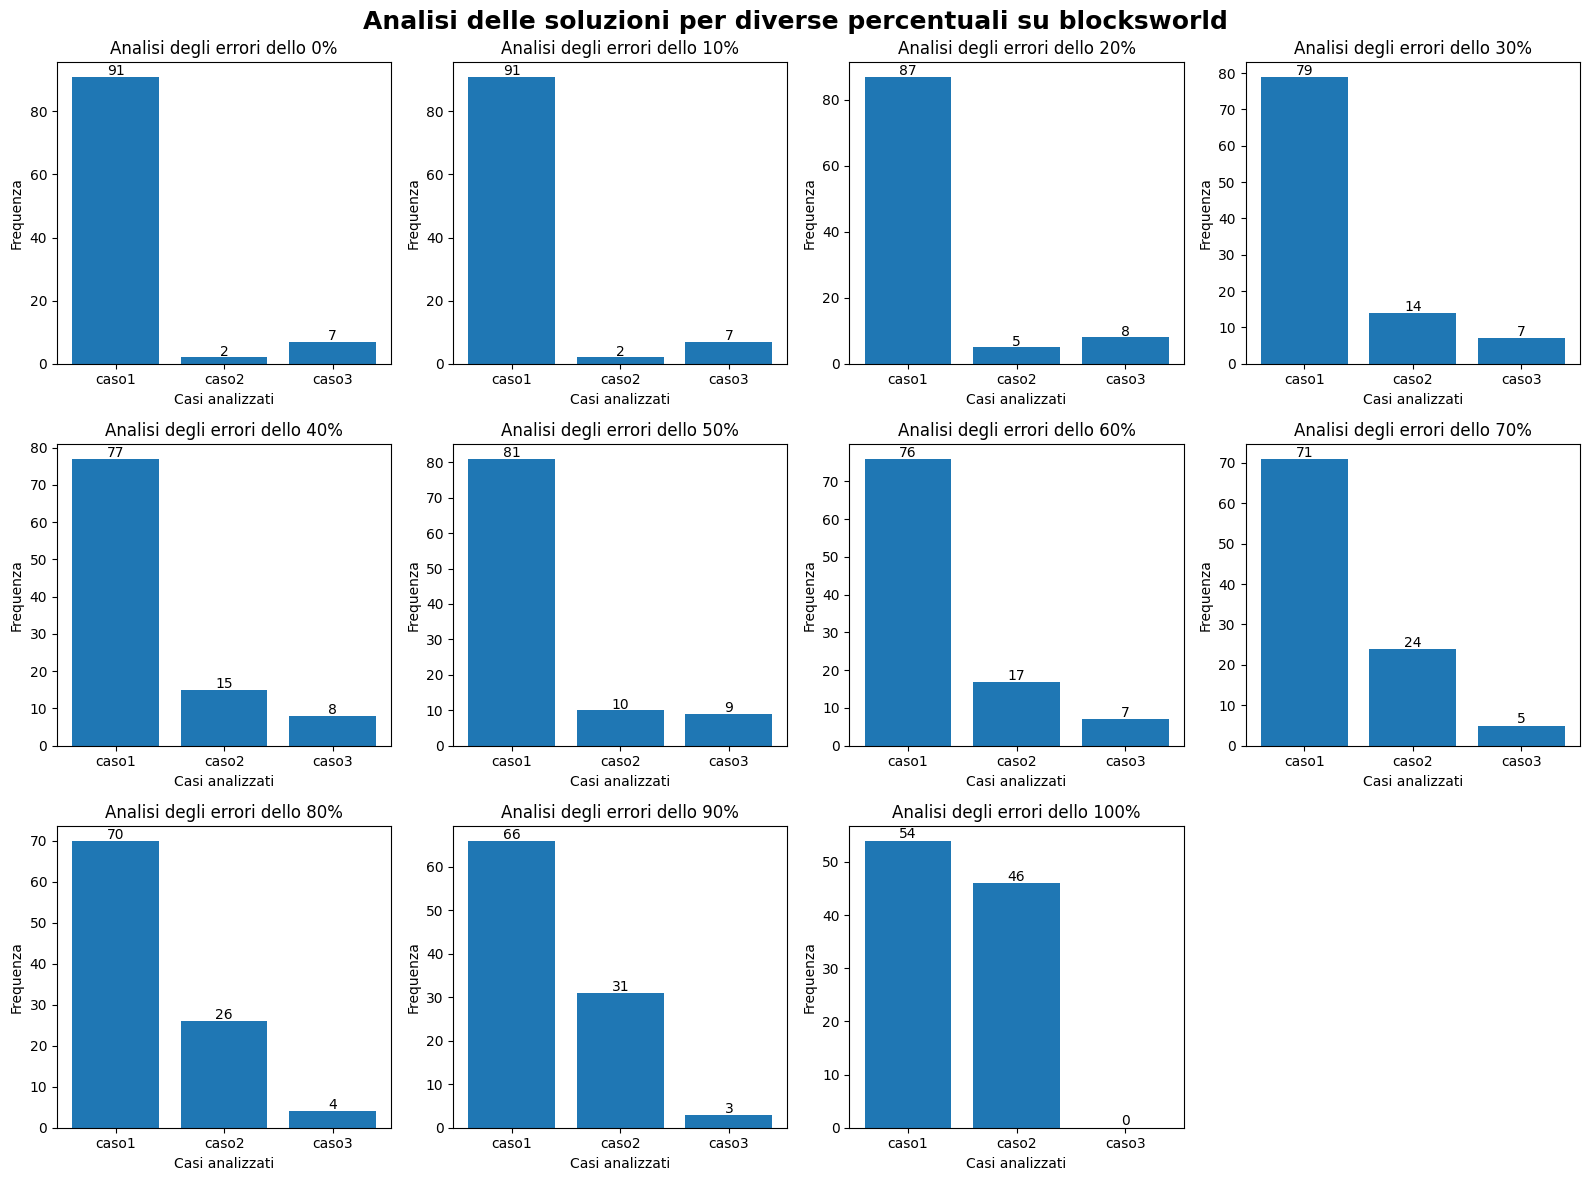

In [74]:
n_plots = len(percentuali)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su blocksworld', fontsize=18, fontweight='bold')

for i, (percentage, casi) in enumerate(percentuali.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi.keys(), casi.values())
    ax.set_title(f'Analisi degli errori dello {percentage}%')
    for j, v in enumerate(casi.values()):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

# GR offline

## creazione dict azioni osservate

In [2]:
def get_planner_dict(domain,perc):
    dataset_dir = f"/root/mzizioli/planGPT-OGR/{domain}-dataset-tesi/{perc}"

    planner_dict = {}
    counter = 0
    medium_plan_len = 0    
    
    for folder in os.listdir(dataset_dir): 
        convert_action_b1 = {}
        name = folder
        name = name.replace("_100", "")
        name = name.replace("_full", "")     
        name = name.replace("_10", "")
        name = name.replace("_30", "")
        name = name.replace("_50", "")
        name = name.replace("_70", "")
        name = name.replace("_1", "")
        name = name.replace("_0", "")
        
        
        for file in os.listdir(os.path.join(dataset_dir, folder)):
            path = os.path.join(dataset_dir, folder, file)      
            if file == "template.pddl":
                state = initial_state(path)        
            elif file == "obs.dat":
                actions = get_actions(path)    
                
        lettere_conversion = sorted(estrai_lettere(state)) 
        #print(lettere_conversion)
        for idx, lettera in enumerate(lettere_conversion):            
            convert_action_b1[f" {lettera}"] = f" b{idx+1}"
        #print(convert_action_b1)
        convert_action_domain1["blocksworld"] = convert_action_b1    
        
        medium_plan_len += len(actions)
        counter += 1
        if name not in planner_dict:
            planner_dict[name] = {}
        single_plan_dict = {}
        for act in actions:             
            for conversion in convert_action_domain[domain].keys():         
                act = act.replace(conversion, convert_action_domain[domain][conversion])   
            for conversion in convert_action_domain1[domain].keys():         
                act = act.replace(conversion, convert_action_domain1[domain][conversion])         
            if act not in single_plan_dict:
                single_plan_dict[act] = 1
            else:
                single_plan_dict[act] += 1
        planner_dict[name] = single_plan_dict
    medium_plan_len = medium_plan_len / counter
    return planner_dict, medium_plan_len

## creazione dict piani generati

In [3]:
def get_plan_dict(gen_file, domain):
    generated_dict = {}
    medium_plan_len = 0
    counter = 0
        
    with open(gen_file) as f:
        data = json.load(f)
        for problem in data:           
            
            problem_name = problem["name"]
            problem_name = problem_name.replace("_100", "")
            problem_name = problem_name.replace("_full", "")  
            problem_goal = problem["goal"]            
            Tgoal = problem["true_goal"]        
            
            len_min = 1000000
            idx_plan = -1
            num_max_goal_valid = -22
            for idx,plan in enumerate(problem["plans"]):
                
                if plan["result"][0]: 
                    len_generated_plan = len(unite_actions(plan["plan"], list(dict_actions_domain[domain].keys()), domain))
                    if len_generated_plan < len_min:
                        len_min = len_generated_plan
                        idx_plan = idx
                elif len_min == 1000000:             
                    num_goal_valid = sum(plan["result"][1].values())
                    if num_goal_valid > num_max_goal_valid:
                        num_max_goal_valid = num_goal_valid
                        idx_plan = idx   
            
            #print(name)
            actions = problem['plans'][idx_plan]["plan"]
            #print(actions)
            list_actions = unite_actions(
                actions, list(dict_actions_domain[domain].keys()), domain
            )
            list_actions = [x.replace("_", " ") for x in list_actions]
            #print(list_actions)  
            
            metricable = {
                "input": "<|startofplan|> " + problem['input'],
                "actions": actions,
            }
            if parse_problem(metricable, domain)[0] is False:                
                continue
            
            medium_plan_len += len(list_actions)
            counter += 1
            
            if problem_name not in generated_dict:
                generated_dict[problem_name] = {} 
                goals = [] 
            goal = {}         
            single_plan_dict = {}
            
            
            for act in list_actions:                
                if act not in single_plan_dict:
                    single_plan_dict[act] = 1
                else:
                    single_plan_dict[act] += 1             
            goal = {"goal":problem_goal,"true_goal":Tgoal,"plan_dict":single_plan_dict}    
            goals.append(goal)  
            generated_dict[problem_name] = goals
            
    return generated_dict, medium_plan_len/counter

## funzione della metrica

In [4]:
# planner - generated
def calculate_plan_distance(first_dict, second_dict):                    
    complete_result = []
    
    for key in first_dict:                
        if key not in second_dict:
            print("Errore ", key, " non trovato")
            complete_result.append(-2.0)             
            continue
        
        results = []
        idx_true = -1
        for idx,goal in enumerate(second_dict[key]): 
            result = 0
            for act in first_dict[key]:                           
                if act in goal["plan_dict"]:                         
                    result += 1                   
                else:
                    result += 0
            if goal["true_goal"]:
                idx_true = idx            
            results.append(result)
            
        massimo = max(results)
        indici_massimi = [i for i, x in enumerate(results) if x == massimo]
        #print(results)
        #print(indici_massimi, idx_true)     
        if idx_true == -1:
            complete_result.append(-1.0)   
        else:
            if idx_true in indici_massimi:
                complete_result.append(1/len(indici_massimi))
            else:
                complete_result.append(0)               
    return complete_result

## calcolo della metrica

In [5]:
#df = pd.DataFrame(columns=["domain", "method", "mean_len"])
#df_plan_distance = pd.DataFrame(columns=["domain", "method", "tot_plan_distance", "mean_plan_distance"])
domain = "blocksworld"
planner_dict_10, mean_planner_len_10 = get_planner_dict(domain, 10)
planner_dict_30, mean_planner_len_30 = get_planner_dict(domain, 30)
planner_dict_50, mean_planner_len_50 = get_planner_dict(domain, 50)
planner_dict_70, mean_planner_len_70 = get_planner_dict(domain, 70)
planner_dict_100, mean_planner_len_100 = get_planner_dict(domain, 100)
#df.loc[len(df)] = [domain, "planner", mean_planner_len_10]

gen_file = f"/root/mzizioli/planGPT-OGR/{domain}-generations-tesi/sampling/generation_output_100p_NoAction.json"
generated_dict, mean_gen_len = get_plan_dict(gen_file, domain)
#df.loc[len(df)] = [domain, "sampling", mean_gen_len]
       
#print(f"Len generated dict sampling - {domain}: {len(generated_dict)}")
#print(f"Len planner dict sampling - {domain}: {len(planner_dict)}")
complete_result_10 = calculate_plan_distance(planner_dict_10, generated_dict)
complete_result_30 = calculate_plan_distance(planner_dict_30, generated_dict)
complete_result_50 = calculate_plan_distance(planner_dict_50, generated_dict)
complete_result_70 = calculate_plan_distance(planner_dict_70, generated_dict)
complete_result_100 = calculate_plan_distance(planner_dict_100, generated_dict)
#df_plan_distance.loc[len(df_plan_distance)] = [domain, "sampling + planner-gen", complete_result[-1], complete_result[-1]/len(complete_result)]
#print(f"sampling - {domain}: {complete_result}")

complete_results = [complete_result_10,complete_result_30,complete_result_50,complete_result_70,complete_result_100]


## calcolo accuracy

In [13]:
Accuracy = []
casi_valori = []
casi_nomi = ["caso1","caso2","caso3", "caso4","caso5"]

for complete_result in complete_results:
    caso4 = complete_result.count(-1.0)
    caso5 = complete_result.count(-2.0)
    caso1 = complete_result.count(0.0)
    caso3 = complete_result.count(1.0)
    caso2 = len(complete_result) - caso1 - caso3 - caso4 - caso5    
    casi_valore = [caso1, caso2, caso3, caso4, caso5]
    casi_valori.append(casi_valore)

    accuracy = round((sum(complete_result)+caso4+(caso5*2))/len(complete_result),3)
    print("Numero di problemi che non hanno generato piani validi: ", caso5)
    print("Accuracy: ", accuracy)
    Accuracy.append(accuracy)
    
print(casi_valori) 
print(Accuracy)


Numero di problemi che non hanno generato piani validi:  0
Accuracy:  0.12
Numero di problemi che non hanno generato piani validi:  0
Accuracy:  0.267
Numero di problemi che non hanno generato piani validi:  0
Accuracy:  0.452
Numero di problemi che non hanno generato piani validi:  0
Accuracy:  0.554
Numero di problemi che non hanno generato piani validi:  0
Accuracy:  0.877
[[25, 73, 2, 0, 0], [23, 63, 14, 0, 0], [16, 48, 36, 0, 0], [17, 37, 46, 0, 0], [2, 18, 80, 0, 0]]
[0.12, 0.267, 0.452, 0.554, 0.877]


## grafico analisi soluzioni

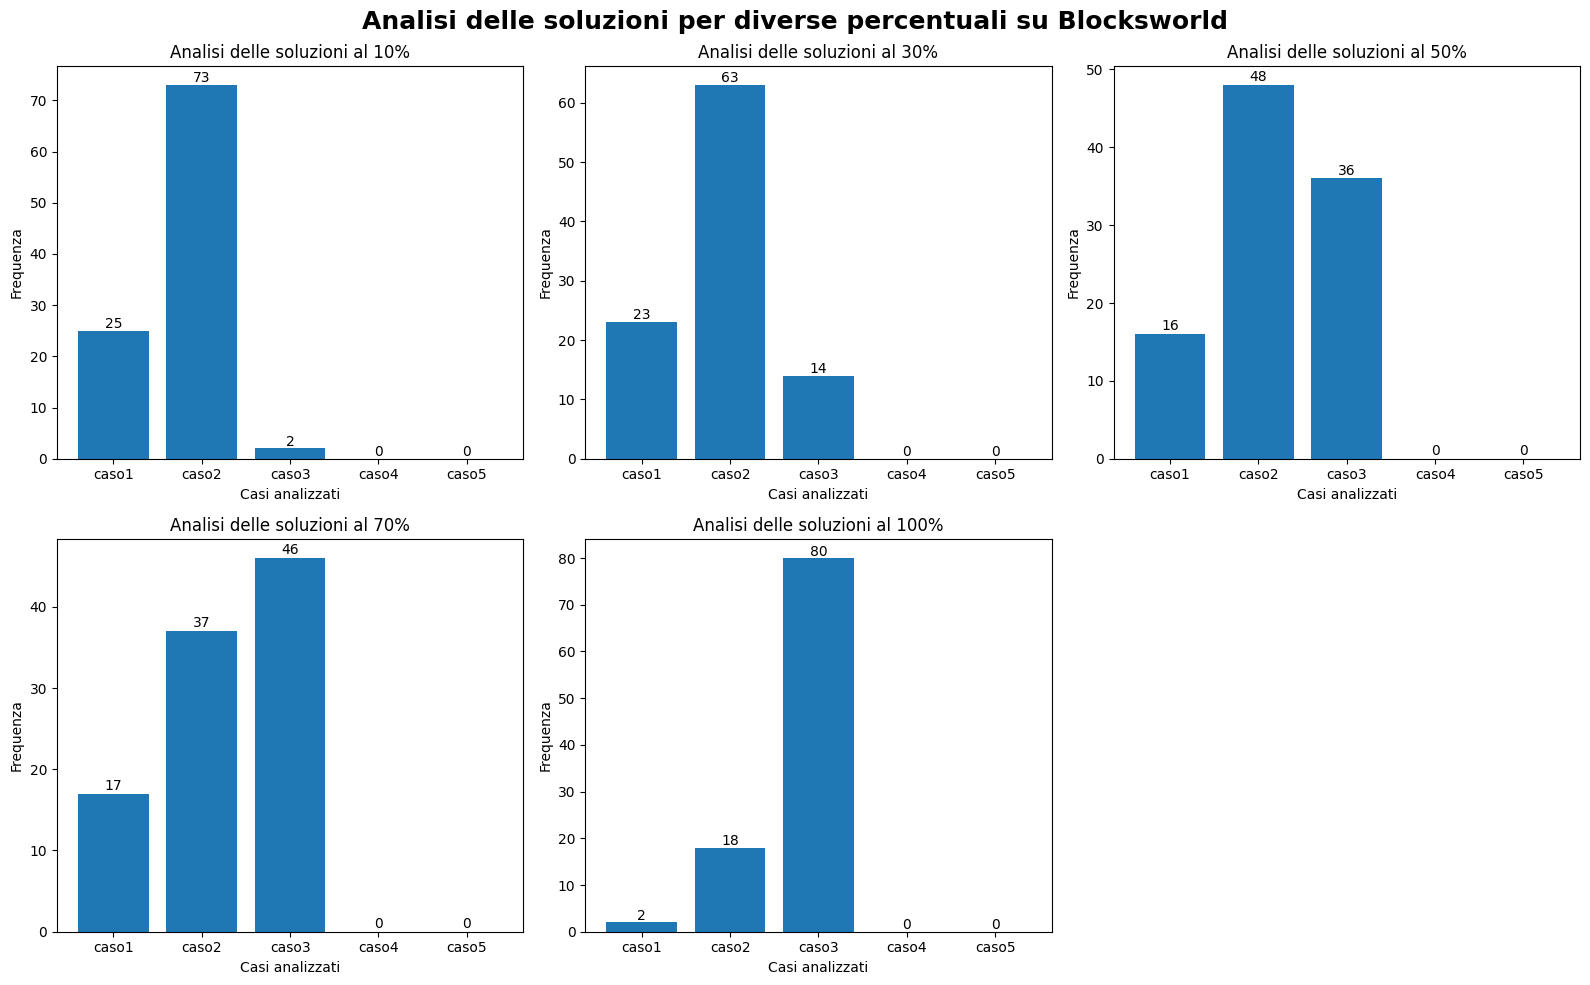

In [22]:
percentuali = [10,30,50,70,100]
n_plots = len(percentuali)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
fig.suptitle('Analisi delle soluzioni per diverse percentuali su Blocksworld', fontsize=18, fontweight='bold')

for i, (percentage, casi) in enumerate(zip(percentuali,casi_valori)):
    ax = axs[i // n_cols, i % n_cols]
    ax.bar(casi_nomi, casi)
    ax.set_title(f'Analisi delle soluzioni al {percentage}%')
    for j, v in enumerate(casi):
        ax.text(j, v + 0.5, str(v), color='black', ha='center')
    ax.set_xlabel('Casi analizzati')
    ax.set_ylabel('Frequenza')

for i in range(n_plots, n_rows*n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.tight_layout()
plt.show()

## grafico accuracy

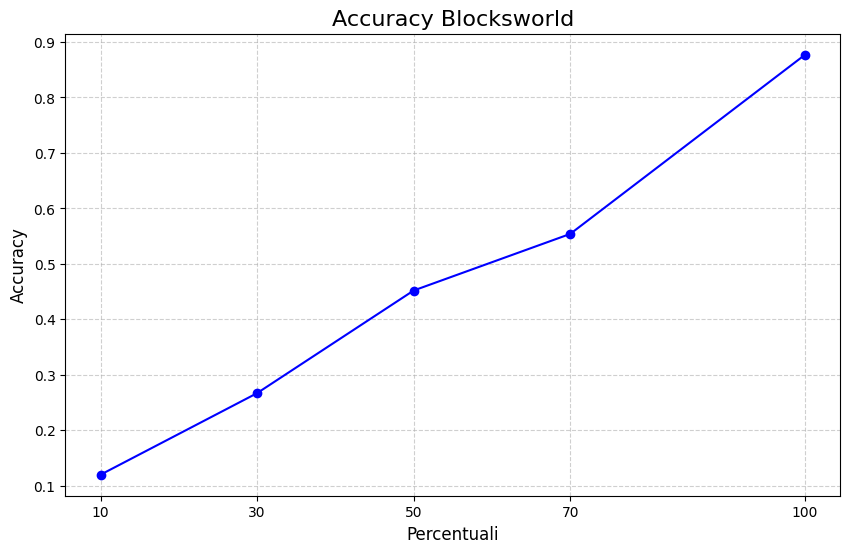

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(percentuali, Accuracy, marker='o', linestyle='-', color='b')

plt.title('Accuracy Blocksworld', fontsize=16)
plt.xlabel('Percentuali', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(percentuali)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show() 

# grafici

In [104]:
import random
random.shuffle(grafics_data)

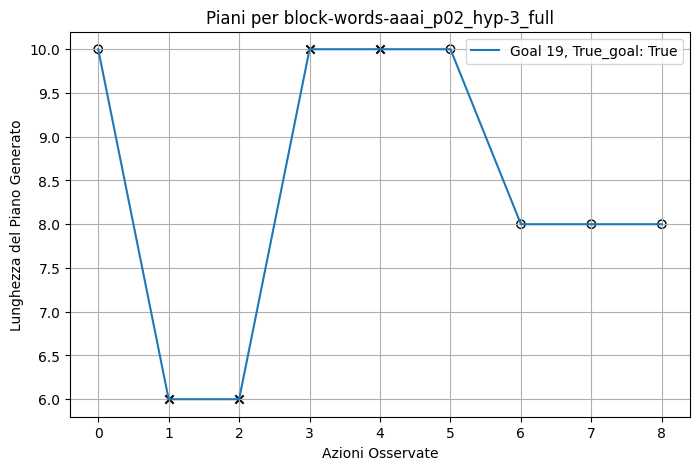

In [15]:
k=0
num_x = 0

for problem_data in grafics_data:
    if k==1:
        break
    k+=1
    problem_name = problem_data['problem']
    goals = problem_data['goals']
    
    plt.figure(figsize=(8, 5))
    
    for idx, goal in enumerate(goals):  
        # plt.figure(figsize=(10, 6))       
        goal_name = goal['goal']
        actions = goal['actions']
        len_plans = goal['len_plans']
        valid_plans = goal['valid_plans']
        Tgoal = goal["true_goal"]
        
        if Tgoal == True:
            # Usare marker diversi per piani validi e non validi
            markers = ['o' if valid else 'x' for valid in valid_plans]                              
                
            # Aggiungere la linea per il piano
            plt.plot(actions, len_plans, label=f'Goal {idx + 1}, True_goal: {Tgoal}')  # Modifica qui
            
            # Aggiungere i punti con marker diversi
            for action, length, marker in zip(actions, len_plans, markers):
                plt.scatter(action, length, marker=marker, color='red' if marker == 'x' else "black", facecolor="none" if marker == 'o' else "black")
            
          
        # plt.title(f'Piani per {problem_name} - Goal {idx + 1}')
        # plt.xlabel('Azioni Osservate')
        # plt.ylabel('Lunghezza del Piano Generato')        
        # plt.xticks(np.arange(min(actions), max(actions) + 1, 1))  # Tick sull'asse X ogni unità
        # plt.legend()
        # plt.grid()
        # plt.show()      
            

    plt.xticks(np.arange(min(actions), max(actions) + 1, 1))  # Tick sull'asse X ogni unità  
    plt.title(f'Piani per {problem_name}')
    plt.xlabel('Azioni Osservate')
    plt.ylabel('Lunghezza del Piano Generato')
    plt.legend()
    plt.grid()
    plt.show()
    


# test azione generata uguale azione futura passata

Per ciascun problema, il numero di volte in cui la prima azione generata da PlanGPT corrisponde all’osservazione successiva, sia in valore assoluto che in percentuale rispetto alla lunghezza del piano originale

In [4]:
domain = "blocksworld"
file_path = '/root/mzizioli/planGPT-OGR/blocksworld-generations-tesi/greedy/generation_output_100p_actions_test.json'
with open(file_path, 'r') as file:
    data = json.load(file)

problem = ""
goal = ""
actions = []
len_plans = []
valid_plans = []
len_actions = 0
data_cont = []
cont=0
tot_cont=0
g={}
dati = []

for output in data:   
     
    new_problem = output.get("name")    
    if problem == "":
        problem = new_problem
    
    generated_plan = output["plans"][0]["plan"]
    passed_actions = output.get("action")  
    actions = output.get("actions")
    
    generated_plan = unite_actions(generated_plan, list(dict_actions_domain[domain].keys()), domain)
    actions = unite_actions(actions, list(dict_actions_domain[domain].keys()), domain)        
    passed_actions = unite_actions(passed_actions, list(dict_actions_domain[domain].keys()), domain)  
    len_passed_actions = len(passed_actions)
    
    #print(output["plans"][0]["result"][0], len_passed_actions)
    
    if len_actions == 0:
        len_actions = len(actions)   
        for i in range(len_actions+1):
            g[i]= 0    
    
    if new_problem != problem: 
        data_cont.append({"problem": problem, "cont": cont, "len_actions": len_actions})
        dati.append(g)
        len_actions = len(actions)
        g = {}
        for i in range(len_actions+1):
            g[i]= 0 
        tot_cont+=cont
        cont=0
        problem = new_problem
    # print("passed_actions", passed_actions)    
    # print("actions: ", actions)
    # print("generated_plan: ",generated_plan)
    if len_passed_actions<(len(actions)) and len_passed_actions<len(generated_plan): 
        if generated_plan[len_passed_actions] == actions[len_passed_actions]: 
            #print("==")
            cont+=1 
            g[len_passed_actions] += 1   
      
dati.append(g)      
data_cont.append({"problem": problem, "cont": cont, "len_actions": len_actions})  
tot_cont+=cont           
for i in data_cont:
    print(i)

print(tot_cont)

dati_percentuale=copy.deepcopy(dati)
for j in dati_percentuale:   
    somma = sum(j.values())     
    for k in j: 
        j[k]= j[k]/somma*100            

{'problem': 'block-words-aaai_p02_hyp-3_full', 'cont': 36, 'len_actions': 8}
{'problem': 'block-words_p02_hyp-3_full', 'cont': 45, 'len_actions': 8}
{'problem': 'block-words_p02_hyp-0_full', 'cont': 71, 'len_actions': 8}
{'problem': 'block-words_p02_hyp-6_full', 'cont': 17, 'len_actions': 10}
{'problem': 'block-words-aaai_p03_hyp-0_full', 'cont': 8, 'len_actions': 6}
{'problem': 'block-words_p03_hyp-13_full', 'cont': 41, 'len_actions': 12}
{'problem': 'block-words_p03_hyp-15_full', 'cont': 8, 'len_actions': 6}
{'problem': 'block-words_p03_hyp-12_full', 'cont': 32, 'len_actions': 8}
{'problem': 'block-words_p02_hyp-19_full', 'cont': 12, 'len_actions': 6}
{'problem': 'block-words_p01_hyp-19_full', 'cont': 26, 'len_actions': 8}
{'problem': 'block-words-aaai_p02_hyp-0_full', 'cont': 22, 'len_actions': 6}
{'problem': 'block-words_p01_hyp-16_full', 'cont': 44, 'len_actions': 10}
{'problem': 'block-words-aaai_p03_hyp-4_full', 'cont': 57, 'len_actions': 14}
{'problem': 'block-words-aaai_p01_hy

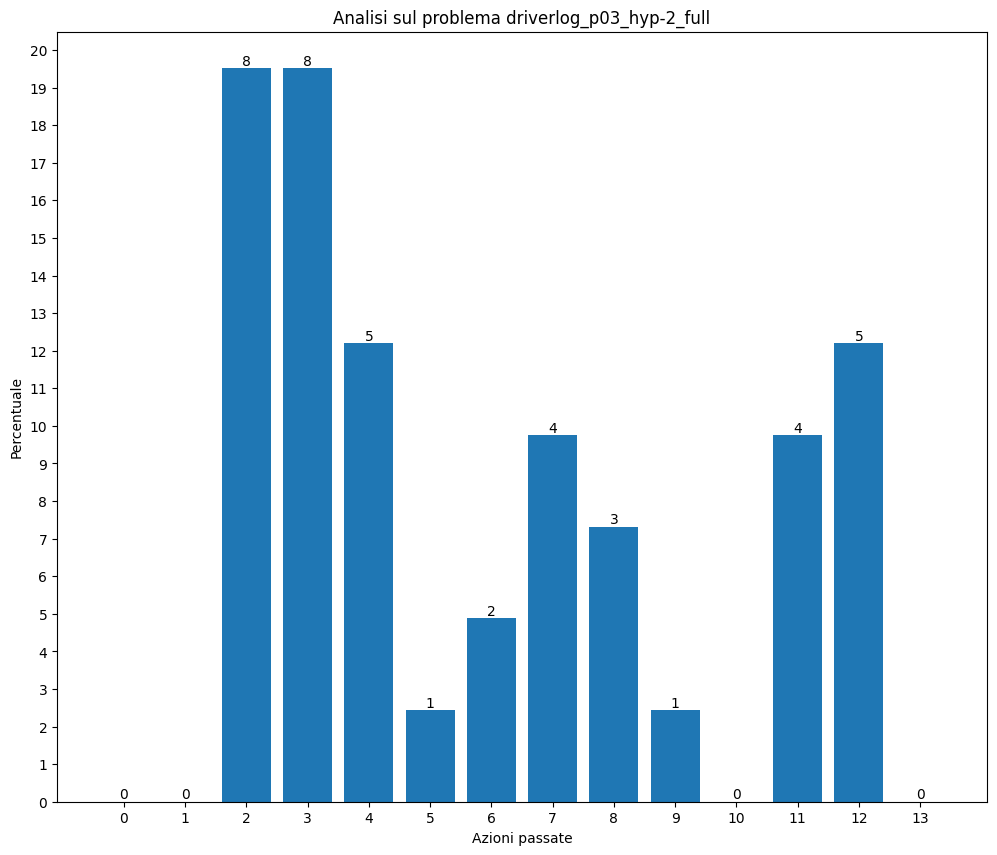

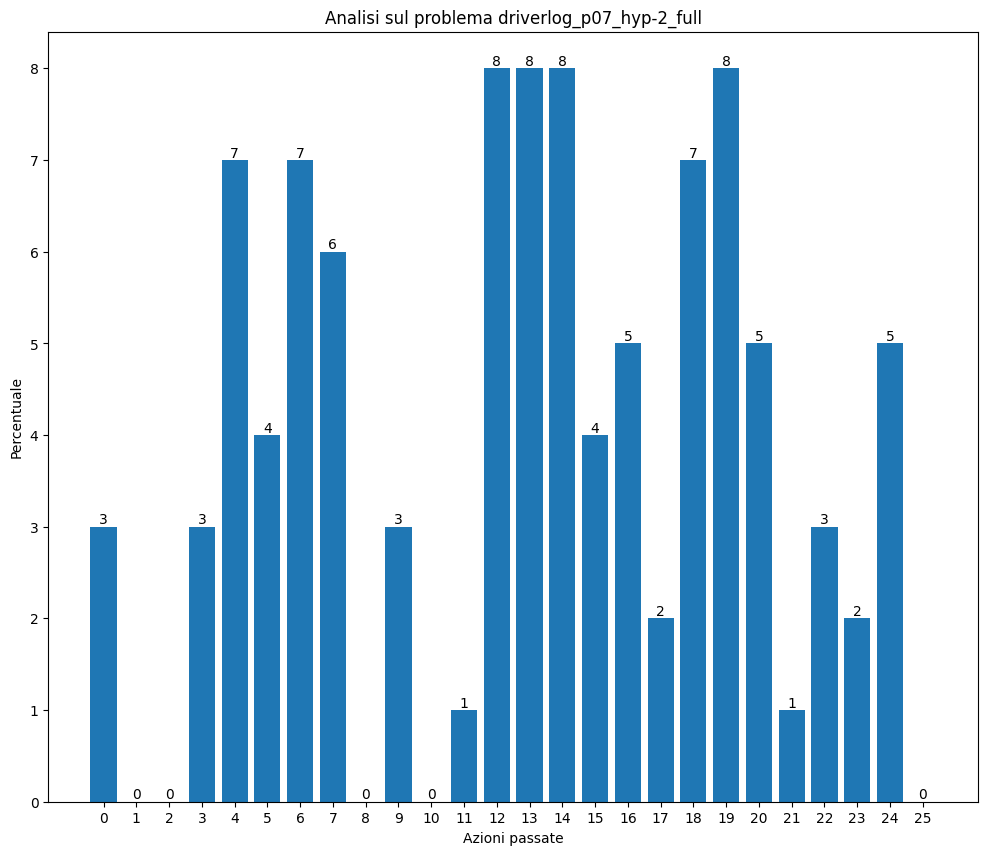

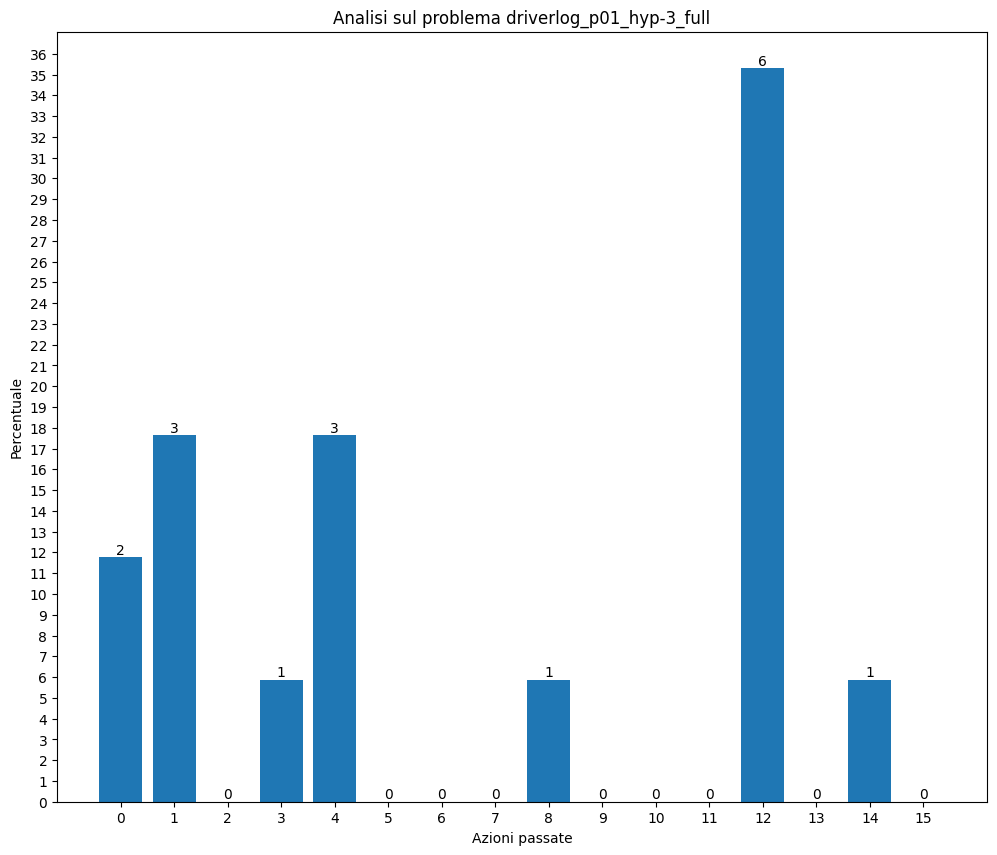

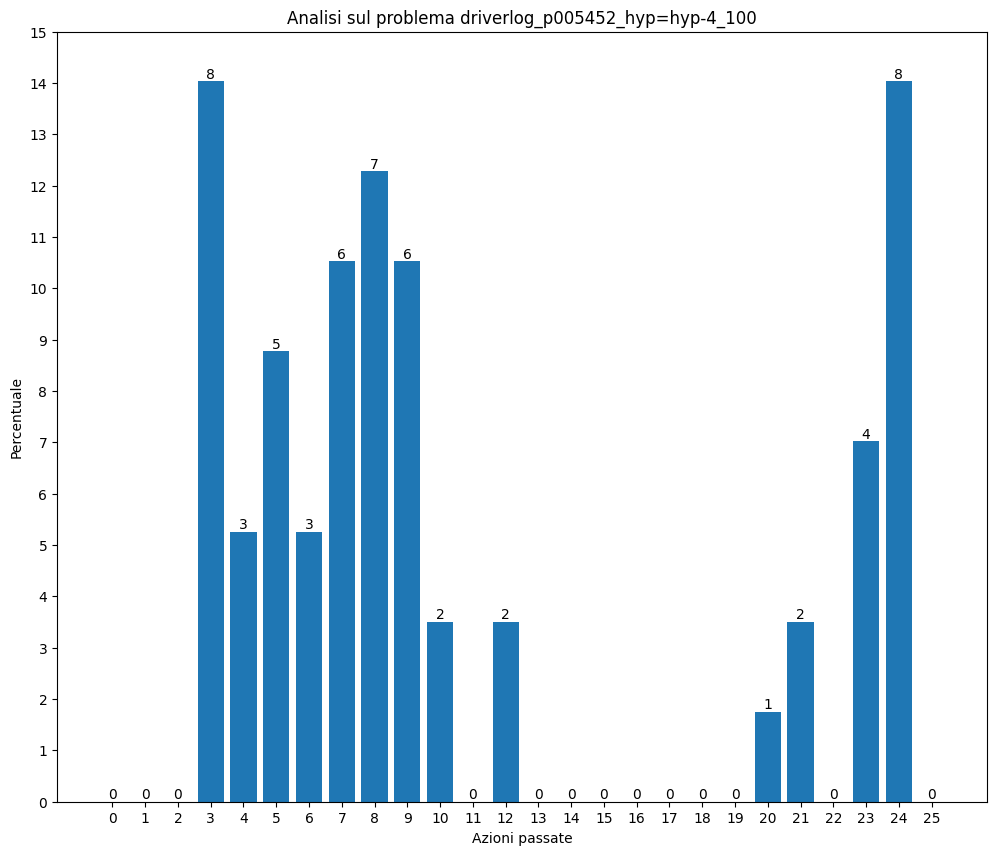

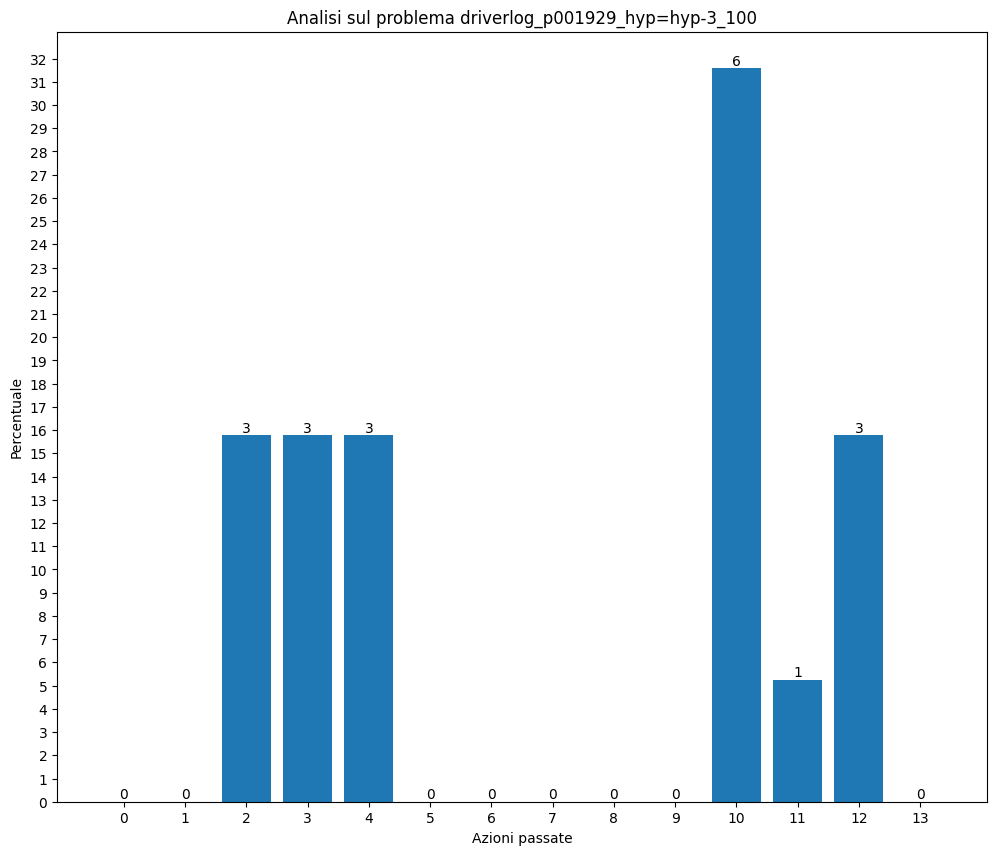

In [ ]:
k=0
for data_percentuale,problem,data in zip(dati_percentuale, data_cont, dati):
    if k==5:
        break
    k+=1
    problem_name = problem['problem']  
    plt.figure(figsize=(12, 10))
    bars=plt.bar(data_percentuale.keys(), data_percentuale.values())
    for bar,d in zip(bars,data.values()):
        yval = d
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(yval), 
             ha='center', va='bottom', fontsize=10)  # Aggiungi il valore)
        
    plt.title(f"Analisi sul problema {problem_name}")
    plt.ylabel('Percentuale')
    plt.xlabel('Azioni passate')
    plt.xticks(np.arange(min(data_percentuale.keys()), max(data_percentuale.keys()) + 1, 1))  # Tick sull'asse X ogni unità 
    plt.yticks(np.arange(0, max(data_percentuale.values()) + 1, 1))  # Tick sull'asse X ogni unità 